##### Drive

In [ ]:
#Uncomment all if the notebook is opened on Google Collab
#from pydrive.auth import GoogleAuth
#from pydrive.drive import GoogleDrive
#from google.colab import auth
#from oauth2client.client import GoogleCredentials

#auth.authenticate_user() 
#gauth = GoogleAuth()
#gauth.credentials = GoogleCredentials.get_application_default()
#drive = GoogleDrive(gauth)

#downloaded = drive.CreateFile({'id':"1Ob8eKK0ajYN6YCwM9XTUeyevLwTn3T_F"})  
#downloaded.GetContentFile('donors.csv')

##### Libraries & Packages

In [ ]:
#!conda install git
#!pip install -U git+https://github.com/joaopfonseca/SOMPY.git #If this takes too long to download, please paste the command on the conda prompt
!pip install -r requirements_DM.txt

In [ ]:
import pandas as pd
import numpy as np
import scipy as sc
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
from math import ceil
from pandas_profiling import ProfileReport
import scipy.cluster.hierarchy as shc
from sklearn import datasets
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
import category_encoders as ce
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo
from sklearn.decomposition import PCA
from pyclustertend import hopkins
from sklearn.preprocessing import scale
import warnings
import sompy
from sompy.visualization.mapview import View2D
from sompy.visualization.bmuhits import BmuHitsView
from sompy.visualization.hitmap import HitMapView
from sklearn.neighbors import NearestNeighbors
from math import isnan
from random import sample
from numpy.random import uniform
import matplotlib.cm as cm
from sklearn.base import clone
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import silhouette_score, silhouette_samples

# for better resolution plots
%config InlineBackend.figure_format = 'retina' # optionally, you can change 'svg' to 'retina'

%matplotlib inline

##### Functions

In [ ]:
def empty_space_Value_to_binary(df, column, value):
    '''
    This function turns a binary variable with values ' ' or any given string in to 0 or 1
    It needs as input the dataframe, the column name and the string symbolizing 1
    (column name and value needs to be between '')
    '''
    df[column] = df[column].map(lambda x: 1 if x == value else 0 if (x == ' ') else x)

def from_object_to_datetime(df, column):
    
    df[column] = pd.to_datetime(df[column], infer_datetime_format=True)

def x_to_bin(df, column): #from sim/nao to binary values
    
    df[column] = df[column].map(lambda x: 1 if x == 'X' else 0)
    
def gender_treatment(df, column): #os valores de U (unknown) e todos os outros valores que n tinham significado algum, vamos por como np.nan
 
    df[column] = df[column].replace(['A', 'U', 'C', ' '], np.nan)

def pandas_profiling(df, title):
    
    profile = ProfileReport(df,
                           title = title,
                           correlations = {'pearson' : {'calculate' : True},
                                          'spearman' : {'calculate' : False},
                                          'kendall' : {'calculate' : False},
                                          'phi_k' : {'calculate' : False},
                                          'cramers' : {'calculate' : False}})
    return profile.to_notebook_iframe()

def pandas_profiling_minimal(df, title):
    
    profile = ProfileReport(df,
                           title = title,
                           minimal = True)
    return profile.to_notebook_iframe()
    
def pandas_profiling_binary(df, title):
    
    profile = ProfileReport(df,
                           title = title,
                           correlations = {'pearson' : {'calculate' : False},
                                          'spearman' : {'calculate' : True},
                                          'kendall' : {'calculate' : False},
                                          'phi_k' : {'calculate' : False},
                                          'cramers' : {'calculate' : False}})
    return profile.to_notebook_iframe()

def hist_box_maker(df,titl, num_of_rows, figx, figy):
    %matplotlib inline
    fig, axes = plt.subplots(num_of_rows, ceil((len(df.columns)*2)/num_of_rows), figsize=(figx, figy))
    temp = (list(df.columns)*2)
    temp.sort()
    # Plot data
    # Iterate across axes objects and associate each histogram (hint: use the ax.hist() instead of plt.hist()):
    i = 0 
    for ax, feat in zip(axes.flatten(), temp):
        
        if i%2 == 0:
            ax.hist(df[feat], bins = 100)
            ax.set_title(feat, y=-0.13)
            pltiswork=feat
            
        else:
            sns.boxplot(x=df[pltiswork], ax = ax)
        
        i+=1
            
    # Layout
    # Add a centered title to the figure:
    title = titl

    plt.suptitle(title)

    plt.show()# All Numeric Variables' Box Plots in one figure
    
def iqr_X(df, X): #Compute IQR

    q1 = df.quantile(.25)
    q3 = df.quantile(.75)

    iqr = (q3 - q1)

    #Compute upper and lower limits
    lower_lim = q1 - X * iqr
    upper_lim = q3 + X * iqr

    filters = []

    for metric in df.columns:
        llim = lower_lim[metric]
        ulim = upper_lim[metric]
        filters.append(df[metric].between(llim, ulim, inclusive = True))
    
    return np.all(filters, 0)

def ohe(df, column_list):
    ohc = OneHotEncoder(sparse = False)
    ohc_feat = ohc.fit_transform(df[column_list])
    ohc_feat_names = ohc.get_feature_names()
    ohc_df = pd.DataFrame(ohc_feat, index = df.index, columns = ohc_feat_names)
    return ohc_df

def missing_zero_values_table(df):
        zero_val = (df == 0.00).astype(int).sum(axis=0)
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mz_table = pd.concat([zero_val, mis_val, mis_val_percent], axis=1)
        mz_table = mz_table.rename(
        columns = {0 : 'Zero Values', 1 : 'Missing Values', 2 : '% of Total Values'})
        mz_table['Total Zero Missing Values'] = mz_table['Zero Values'] + mz_table['Missing Values']
        mz_table['% Total Zero Missing Values'] = 100 * mz_table['Total Zero Missing Values'] / len(df)
        mz_table['Data Type'] = df.dtypes
        mz_table = mz_table[
            mz_table.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns and " + str(df.shape[0]) + " Rows.\n"      
            "There are " + str(mz_table.shape[0]) +
              " columns that have missing values.")
#         mz_table.to_excel('D:/sampledata/missing_and_zero_values.xlsx', freeze_panes=(1,0), index = False)
        return mz_table

def corr_df(x, corr_val):
    '''
    Obj: Drops features that are strongly correlated to other features.
          This lowers model complexity, and aids in generalizing the model.
    Inputs:
          df: features df (x)
          corr_val: Columns are dropped relative to the corr_val input (e.g. 0.8)
    Output: df that only includes uncorrelated features
    '''
    
    # Creates Correlation Matrix and Instantiates
    corr_matrix = x.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    # Iterates through Correlation Matrix Table to find correlated columns
    for i in iters:
        for j in range(i):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = item.values
            if abs(val) >= corr_val:
                # Prints the correlated feature set and the corr val
                print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                drop_cols.append(i)

    drops = sorted(set(drop_cols))[::-1]

    # Drops the correlated columns
    for i in drops:
        col = x.iloc[:, (i+1):(i+2)].columns.values
        x = x.drop(col, axis=1)
    return x


def hierarchical_ontop_of_kmeans1(df):
    %matplotlib inline
    kmeans = KMeans(n_clusters = 200, init = 'k-means++', n_init = 10, random_state = 42, n_jobs = -1)
    kmeans.fit(df)
    #Saving the labls
    centroids_descript = df.copy()
    centroids_descript['labels'] = kmeans.predict(df)
    #kmeans_labels = kmeans.predict(df)
    #Getting the centroid values for each column
    #centroids_descript = pd.concat((df, pd.Series(kmeans_labels, name='labels')), axis=1)
    centroids_descript = centroids_descript.groupby('labels').mean()
    def get_r2_hc(df, link_method, max_nclus, min_nclus=1, dist="euclidean"):
        """This function computes the R2 for a set of cluster solutions given by the application of a hierarchical method.
        The R2 is a measure of the homogenity of a cluster solution. It is based on SSt = SSw + SSb and R2 = SSb/SSt. 
    
        Parameters:
        df (DataFrame): Dataset to apply clustering
        link_method (str): either "ward", "complete", "average", "single"
        max_nclus (int): maximum number of clusters to compare the methods
        min_nclus (int): minimum number of clusters to compare the methods. Defaults to 1.
        dist (str): distance to use to compute the clustering solution. Must be a valid distance. Defaults to "euclidean".
    
        Returns:
        ndarray: R2 values for the range of cluster solutions
        """
        def get_ss(df):
            ss = np.sum(df.var() * (df.count() - 1))
            return ss  # return sum of sum of squares of each df variable
    
        sst = get_ss(df)  # get total sum of squares
    
        r2 = []  # where we will store the R2 metrics for each cluster solution
    
        for i in range(min_nclus, max_nclus+1):  # iterate over desired ncluster range
            cluster = AgglomerativeClustering(n_clusters=i, affinity=dist, linkage=link_method)
            hclabels = cluster.fit_predict(df) #get cluster labels
            df_concat = pd.concat((df, pd.Series(hclabels, name='labels')), axis=1)  # concat df with labels
            ssw_labels = df_concat.groupby(by='labels').apply(get_ss)  # compute ssw for each cluster labels
            ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
            r2.append(ssb / sst)  # save the R2 of the given cluster solution
        
        return np.array(r2)
    # Prepare input
    hc_methods = ["ward", "complete", "average", "single"]
    # Call function defined above to obtain the R2 statistic for each hc_method
    max_nclus = 20
    r2_hc_methods = np.vstack([get_r2_hc(df=centroids_descript, link_method=link, max_nclus=max_nclus) for link in hc_methods]).T
    r2_hc_methods = pd.DataFrame(r2_hc_methods, index=range(1, max_nclus + 1), columns=hc_methods)

    sns.set()
    # Plot data
    fig = plt.figure(figsize=(11,5))
    sns.lineplot(data=r2_hc_methods, linewidth=2.5, markers=["o"]*4)

    # Finalize the plot
    fig.suptitle("R2 plot for various hierarchical methods", fontsize=21)
    plt.gca().invert_xaxis()  # invert x axis
    plt.legend(title="HC methods", title_fontsize=11)
    plt.xticks(range(1, max_nclus + 1))
    plt.xlabel("Number of clusters", fontsize=13)
    plt.ylabel("R2 metric", fontsize=13)

    plt.show()

def hierarchical_ontop_of_kmeans2(df, linkage):
    %matplotlib inline
    kmeans = KMeans(n_clusters = 200, init = 'k-means++', n_init = 10, random_state = 42, n_jobs = -1)
    kmeans.fit(df)
    #Saving the labls
    original_data = df.copy()
    original_data['labels'] = kmeans.predict(df)
    #kmeans_labels = kmeans.predict(df)
    #Getting the centroid values for each column
    #centroids_descript = pd.concat((df, pd.Series(kmeans_labels, name='labels')), axis=1)
    centroids_descript = original_data.groupby('labels').mean()
    distance = 'euclidean'
    hclust1 = AgglomerativeClustering(linkage=linkage, affinity='euclidean', distance_threshold=0, n_clusters=None)
    hclust1.fit_predict(centroids_descript)
    # Adapted from:
    # https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py

    # create the counts of samples under each node (number of points being merged)
    counts = np.zeros(hclust1.children_.shape[0])
    n_samples = len(hclust1.labels_)

    # hclust.children_ contains the observation ids that are being merged together
    # At the i-th iteration, children[i][0] and children[i][1] are merged to form node n_samples + i
    for i, merge in enumerate(hclust1.children_):
        # track the number of observations in the current cluster being formed
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                # If this is True, then we are merging an observation
                current_count += 1  # leaf node
            else:
                # Otherwise, we are merging a previously formed cluster
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    # the hclust.children_ is used to indicate the two points/clusters being merged (dendrogram's u-joins)
    # the hclust.distances_ indicates the distance between the two points/clusters (height of the u-joins)
    # the counts indicate the number of points being merged (dendrogram's x-axis)
    linkage_matrix = np.column_stack(
        [hclust1.children_, hclust1.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    sns.set()
    fig = plt.figure(figsize=(11,5))
    # The Dendrogram parameters need to be tuned
    y_threshold = 100
    dendrogram(linkage_matrix, truncate_mode='level', p=5, color_threshold=y_threshold, above_threshold_color='k')
    plt.title(f'Hierarchical Clustering - {linkage.title()}\'s Dendrogram', fontsize=21)
    plt.xlabel('Number of points in node (or index of point if no parenthesis)')
    plt.ylabel(f'{distance.title()} Distance', fontsize=13)
    plt.show()

    return centroids_descript, original_data
    
def kmeans(df, numclust):
    df_with_labels = df.copy()
    #Defining the KMeans model
    kmeans = KMeans(n_clusters = numclust, init = 'k-means++', n_init = 10, random_state = 42, n_jobs = -1)
    #Fitting it to the data
    kmeans.fit(df)
    #Saving the labels
    df_with_labels['Labels'] = kmeans.predict(df)
    #Getting the centroid values for each column
    clust_descript = df_with_labels.groupby('Labels').mean()
    return df_with_labels, clust_descript


def pca_1(df, columns):

    #Define, fit and transform pca
    pca = PCA()
    pca_feat = pca.fit_transform(df[columns])

    #PCA Table
    print(pd.DataFrame(
        {"Eigenvalue": pca.explained_variance_,
        "Difference": np.insert(np.diff(pca.explained_variance_), 0, 0),
        "Proportion": pca.explained_variance_ratio_,
        "Cumulative": np.cumsum(pca.explained_variance_ratio_)},
        index=range(1, pca.n_components_ + 1)
    ))

    #Plot elbow graph
    %matplotlib inline
    # figure and axes
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # draw plots
    ax1.plot(pca.explained_variance_, marker=".", markersize=12)
    ax2.plot(pca.explained_variance_ratio_, marker=".", markersize=12, label="Proportion")
    ax2.plot(np.cumsum(pca.explained_variance_ratio_), marker=".", markersize=12, linestyle="--", label="Cumulative")

    # customizations
    ax2.legend()
    ax1.set_title("Scree Plot", fontsize=14)
    ax2.set_title("Variance Explained", fontsize=14)
    ax1.set_ylabel("Eigenvalue")
    ax2.set_ylabel("Proportion")
    ax1.set_xlabel("Components")
    ax2.set_xlabel("Components")
    ax1.set_xticks(range(0, pca.n_components_, 2))
    ax1.set_xticklabels(range(1, pca.n_components_ + 1, 2))
    ax2.set_xticks(range(0, pca.n_components_, 2))
    ax2.set_xticklabels(range(1, pca.n_components_ + 1, 2))

    plt.show()

def pca_2(df, columns, n):

    #Compute PC with the "correct" number of components
    pca = PCA(n_components=n)
    pca_feat = pca.fit_transform(df[columns])
    pca_feat_names = [f"PC{i}" for i in range(pca.n_components_)]
    pca_df = pd.DataFrame(pca_feat, index=df.index, columns=pca_feat_names)

    #Standardize the PC's
    scaler = StandardScaler()
    pca_df[pca_df.columns.to_list()] = scaler.fit_transform(pca_df)

    # Reassigning df to contain pca variables
    df = pd.concat([df, pca_df], axis=1)

    def _color_red_or_green(val):
        if val < -0.45:
            color = 'background-color: red'
        elif val > 0.45:
            color = 'background-color: green'
        else:
            color = ''
        return color
    #Loadings of each PC
    loadings = df[columns + pca_feat_names].corr().loc[columns, pca_feat_names]
    return loadings.style.applymap(_color_red_or_green)


def pca_3(df, columns, n):

    #Compute PC with the "correct" number of components
    pca = PCA(n_components=n)
    pc_feat = pca.fit(df[columns])
    pca_feat = pc_feat.transform(df[columns])
    pca_feat_names = [f"PC{i}" for i in range(pca.n_components_)]
    pca_df = pd.DataFrame(pca_feat, index=df.index, columns=pca_feat_names)

    #Standardize the PC's
    scaler = StandardScaler()
    pca_df[pca_df.columns.to_list()] = scaler.fit_transform(pca_df)

    # Reassigning df to contain pca variables
    df = pd.concat([df, pca_df], axis=1)
    return df, pc_feat



def k_means_som(model,num_clust,x_map,y_map):
      kmeans = KMeans(n_clusters=num_clust, init='k-means++', n_init=20, random_state=42)
      nodeclus_labels = model.cluster(kmeans)

      hits  = HitMapView(x_map, y_map,"Clustering", text_size=10)
      hits.show(sm, anotate=True, onlyzeros=False, labelsize=7, cmap="Pastel1")

      plt.show()
      return nodeclus_labels

def SOM_1(df,x,y):
    np.random.seed(42)
    sm = sompy.SOMFactory().build(
        df.values, 
        mapsize=(x, y),
        initialization='random', 
        neighborhood='gaussian',
        training='batch',
        lattice='hexa',
        component_names=df.columns.to_list()
    )
    sm.train(n_job=-1, verbose='info', train_rough_len=100, train_finetune_len=100)
    sns.set()
    view2D = View2D(12,12,"", text_size=10)
    view2D.show(sm, col_sz=3, what='codebook')
    plt.subplots_adjust(top=0.90)
    plt.suptitle("Component Planes", fontsize=20)
    plt.show()
    
    u = sompy.umatrix.UMatrixView(12, 12, 'umatrix', show_axis=True, text_size=8, show_text=True)

    UMAT = u.show(
        sm, 
        distance2=1, 
        row_normalized=False, 
        show_data=True, 
        contooor=True, # Visualize isomorphic curves
        blob=False
    )

    UMAT[1]
    vhts  = BmuHitsView(12,12,"Hits Map")
    vhts.show(sm, anotate=True, onlyzeros=False, labelsize=12, cmap="Blues")
    plt.show()
    return sm

def SOM_Hiera_elbow(df,SOM_model):
      u = sompy.umatrix.UMatrixView(12, 12, 'umatrix', show_axis=True, text_size=8, show_text=True)

      UMAT = u.show(
          SOM_model, 
          distance2=1, 
          row_normalized=False, 
          show_data=False, 
          contooor=True # Visualize isomorphic curves
      )
      distortions = []
      for k in range(1, 10):
          kmeanModel = KMeans(n_clusters=k).fit(df)
          distortions.append(kmeanModel.inertia_)

      plt.figure(figsize=(16,8))
      plt.plot(range(1, 10), distortions, 'bx-')
      plt.xlabel('k')
      plt.ylabel('Distortions')
      plt.title('Dendogram RFM Analysis (All Variables)')
      plt.show()

def full_elbow(df):

    kmeans = KMeans(
        init='k-means++',
        n_init=5,
        random_state=42
    )

    hierarchical = AgglomerativeClustering(
        affinity='euclidean'
    )

    # Obtaining the R² scores for each cluster solution on demographic variables
    r2_scores = {}
    r2_scores['kmeans'] = get_r2_scores(df, kmeans)

    for linkage in ['complete', 'average', 'single', 'ward']:
        r2_scores[linkage] = get_r2_scores(
            df, hierarchical.set_params(linkage=linkage)
        )

    # Visualizing the R² scores for each cluster solution on demographic variables
    pd.DataFrame(r2_scores).plot.line(figsize=(10,7))

    plt.title("Demographic Variables:\nR² plot for various clustering methods\n", fontsize=21)
    plt.legend(title="Cluster methods", title_fontsize=11)
    plt.xlabel("Number of clusters", fontsize=13)
    plt.ylabel("R² metric", fontsize=13)
    plt.show()

def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

def RClass(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    
## for Frequency and Monetary value 

def FMClass(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1    

def avg_silhouette_graph(df):

    # Adapted from:
    # https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py

    # Storing average silhouette metric
    avg_silhouette = []
    for nclus in range(1, 10):
        # Skip nclus == 1
        if nclus == 1:
            continue
        

        # Initialize the KMeans object with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        kmclust = KMeans(n_clusters=nclus, init='k-means++', n_init=5, random_state=42)
        cluster_labels = kmclust.fit_predict(df)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed clusters
        silhouette_avg = silhouette_score(df, cluster_labels)
        avg_silhouette.append(silhouette_avg)
        print(f"For n_clusters = {nclus}, the average silhouette_score is : {silhouette_avg}")

        # The average silhouette plot
    # The inertia plot
    plt.figure(figsize=(9,5))
    plt.plot(avg_silhouette)
    plt.ylabel("Average silhouette")
    plt.xlabel("Number of clusters")
    plt.title("Average silhouette plot over clusters", size=15)
    plt.show()


def get_ss(df):
    """Computes the sum of squares for all variables given a dataset
    """
    ss = np.sum(df.var() * (df.count() - 1))
    return ss  # return sum of sum of squares of each df variable

def r2(df, labels):  
    sst = get_ss(df)
    ssw = np.sum(df.groupby(labels).apply(get_ss))
    return 1 - ssw/sst

def get_r2_scores(df, clusterer, min_k=2, max_k=10):
    """
    Loop over different values of k. To be used with sklearn clusterers.
    """
    r2_clust = {}
    for n in range(min_k, max_k):
        clust = clone(clusterer).set_params(n_clusters=n) #By using clone we don't have to initialize a new instance 
        #every time, as long as it is an sklearn object it can be cloned, it doesn't mater if it a kmeans or 
        #hierarchical, for example
        labels = clust.fit_predict(df)
        r2_clust[n] = r2(df, labels)
    return r2_clust

def SOM_Labeler(df,model,k_som):
    nodes = model.get_node_vectors()

    df_nodes = pd.DataFrame(nodes, columns=df.columns.to_list())
    df_nodes['label'] = k_som

    bmus_map = model.find_bmu(df[df.columns.to_list()])[0]  # get bmus for each observation in df

    df_bmus = pd.DataFrame(
        np.concatenate((df, np.expand_dims(bmus_map,1)), axis=1),
        index=df.index, columns=np.append(df.columns,"BMU")
    )
    df_final = df_bmus.merge(df_nodes['label'], 'left', left_on="BMU", right_index=True)

    df_final_centroids=df_final.drop(columns='BMU').groupby('label').mean()
    return df_final,df_final_centroids

def silhouette_graph(df, nclus):

    # Adapted from:
    # https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py

    # Storing average silhouette metric
    avg_silhouette = []

    # Create a figure
    fig = plt.figure(figsize=(13, 7))

    # Initialize the KMeans object with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    kmclust = KMeans(n_clusters=nclus, init='k-means++', n_init=5, random_state=42)
    cluster_labels = kmclust.fit_predict(df)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed clusters
    silhouette_avg = silhouette_score(df, cluster_labels)
    avg_silhouette.append(silhouette_avg)
    print(f"For n_clusters = {nclus}, the average silhouette_score is : {silhouette_avg}")

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(df, cluster_labels)

    y_lower = 10
    for i in range(nclus):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
            
        # Get y_upper to demarcate silhouette y range size
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
            
        # Filling the silhouette
        color = cm.nipy_spectral(float(i) / nclus)
        plt.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    plt.title("The silhouette plot for the various clusters.")
    plt.xlabel("The silhouette coefficient values")
    plt.ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    plt.axvline(x=silhouette_avg, color="red", linestyle="--")
        
    # The silhouette coefficient can range from -1, 1
    xmin, xmax = np.round(sample_silhouette_values.min() -0.1, 2), np.round(sample_silhouette_values.max() + 0.1, 2)
    plt.xlim([xmin, xmax])
        
    # The (nclus+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    plt.ylim([0, len(df) + (nclus + 1) * 10])

    plt.yticks([])  # Clear the yaxis labels / ticks
    plt.xticks(np.arange(xmin, xmax, 0.1))

def k_means_elbow(df, min_clust, max_clust, title):
    distortions = []
    for k in range(1, 10):
        kmeanModel = KMeans(n_clusters=k, init='k-means++', n_init=5, random_state=42).fit(df)
        distortions.append(kmeanModel.inertia_)

    plt.figure(figsize=(16,8))
    plt.plot(range(1, 10), distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Inertia')
    plt.title(title)
    plt.show()

def hierarchical_elbow(df):
    centroids_descript = df.copy()
    def get_r2_hc(df, link_method, max_nclus, min_nclus=1, dist="euclidean"):
        """This function computes the R2 for a set of cluster solutions given by the application of a hierarchical method.
        The R2 is a measure of the homogenity of a cluster solution. It is based on SSt = SSw + SSb and R2 = SSb/SSt. 
    
        Parameters:
        df (DataFrame): Dataset to apply clustering
        link_method (str): either "ward", "complete", "average", "single"
        max_nclus (int): maximum number of clusters to compare the methods
        min_nclus (int): minimum number of clusters to compare the methods. Defaults to 1.
        dist (str): distance to use to compute the clustering solution. Must be a valid distance. Defaults to "euclidean".
    
        Returns:
        ndarray: R2 values for the range of cluster solutions
        """
        def get_ss(df):
            ss = np.sum(df.var() * (df.count() - 1))
            return ss  # return sum of sum of squares of each df variable
    
        sst = get_ss(df)  # get total sum of squares
    
        r2 = []  # where we will store the R2 metrics for each cluster solution
    
        for i in range(min_nclus, max_nclus+1):  # iterate over desired ncluster range
            cluster = AgglomerativeClustering(n_clusters=i, affinity=dist, linkage=link_method)
            hclabels = cluster.fit_predict(df) #get cluster labels
            df_concat = pd.concat((df, pd.Series(hclabels, name='labels')), axis=1)  # concat df with labels
            ssw_labels = df_concat.groupby(by='labels').apply(get_ss)  # compute ssw for each cluster labels
            ssb = sst - np.sum(ssw_labels)  
            r2.append(ssb / sst)  
        
        return np.array(r2)
    # Prepare input
    hc_methods = ["ward", "complete", "average", "single"]
    # Call function defined above to obtain the R2 statistic for each hc_method
    max_nclus = 20
    r2_hc_methods = np.vstack([get_r2_hc(df=centroids_descript, link_method=link, max_nclus=max_nclus) for link in hc_methods]).T
    r2_hc_methods = pd.DataFrame(r2_hc_methods, index=range(1, max_nclus + 1), columns=hc_methods)

    sns.set()
    # Plot data
    fig = plt.figure(figsize=(11,5))
    sns.lineplot(data=r2_hc_methods, linewidth=2.5, markers=["o"]*4)

    # Finalize the plot
    fig.suptitle("R2 plot for various hierarchical methods", fontsize=21)
    plt.gca().invert_xaxis()  # invert x axis
    plt.legend(title="HC methods", title_fontsize=11)
    plt.xticks(range(1, max_nclus + 1))
    plt.xlabel("Number of clusters", fontsize=13)
    plt.ylabel("R2 metric", fontsize=13)

    plt.show()

def hierarchical(df, numclust, link_method):
    df_with_labels = df.copy()
    #Defining the KMeans model
    hierarchical = AgglomerativeClustering(n_clusters=numclust, affinity='euclidean', linkage=link_method)
    #Saving the labels
    df_with_labels['Labels'] = hierarchical.fit_predict(df)
    #Getting the centroid values for each column
    clust_descript = df_with_labels.groupby('Labels').mean()
    return df_with_labels, clust_descript

def hierarchical_som(model,num_clust,x_map,y_map):
      hierclust = AgglomerativeClustering(n_clusters=num_clust, linkage='ward')
      nodeclus_labels = sm.cluster(hierclust)

      hits  = HitMapView(x_map, y_map,"Clustering",text_size=10)
      hits.show(sm, anotate=True, onlyzeros=False, labelsize=7, cmap="Pastel1")

      plt.show()
      return nodeclus_labels

def SOM_Labeler(df,model,k_som):
    nodes = model.get_node_vectors()

    df_nodes = pd.DataFrame(nodes, columns=df.columns.to_list())
    df_nodes['label'] = k_som

    bmus_map = model.find_bmu(df[df.columns.to_list()])[0]  # get bmus for each observation in df

    df_bmus = pd.DataFrame(
        np.concatenate((df, np.expand_dims(bmus_map,1)), axis=1),
        index=df.index, columns=np.append(df.columns,"BMU")
    )
    df_final = df_bmus.merge(df_nodes['label'], 'left', left_on="BMU", right_index=True)

    df_final_centroids=df_final.drop(columns='BMU').groupby('label').mean()
    return df_final,df_final_centroids

def cluster_profiles(df, label_columns, figsize, compar_titles=None):
    """
    Pass df with labels columns of one or multiple clustering labels. 
    Then specify this label columns to perform the cluster profile according to them.
    """
    if compar_titles == None:
        compar_titles = [""]*len(label_columns)
        
    sns.set()
    fig, axes = plt.subplots(nrows=len(label_columns), ncols=2, figsize=figsize, squeeze=False)
    for ax, label, titl in zip(axes, label_columns, compar_titles):
        # Filtering df
        drop_cols = [i for i in label_columns if i!=label]
        dfax = df.drop(drop_cols, axis=1)
        
        # Getting the cluster centroids and counts
        centroids = dfax.groupby(by=label, as_index=False).mean()
        counts = dfax.groupby(by=label, as_index=False).count().iloc[:,[0,1]]
        counts.columns = [label, "counts"]
        
        # Setting Data
        pd.plotting.parallel_coordinates(centroids, label, color=sns.color_palette(), ax=ax[0])
        sns.barplot(x=label, y="counts", data=counts, ax=ax[1])

        #Setting Layout
        handles, _ = ax[0].get_legend_handles_labels()
        cluster_labels = ["Cluster {}".format(i) for i in range(1, len(handles)+1)]
        ax[0].annotate(s=titl, xy=(0.95,1.1), xycoords='axes fraction', fontsize=13, fontweight = 'heavy') 
        ax[0].legend(handles, cluster_labels) # Adaptable to number of clusters
        ax[0].axhline(color="black", linestyle="--")
        ax[0].set_title("Cluster Means - {} Clusters".format(len(handles)), fontsize=13)
        ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90)
        ax[1].set_xticklabels(cluster_labels)
        ax[1].set_xlabel("")
        ax[1].set_ylabel("Absolute Frequency")
        ax[1].set_title("Cluster Sizes - {} Clusters".format(len(handles)), fontsize=13)
    
    plt.subplots_adjust(hspace=0.4, top=0.90)
    plt.suptitle("Cluster Simple Profilling", fontsize=23)
    plt.show()

def metrics(y_train, pred_train , y_val, pred_val):
    print('___________________________________________________________________________________________________________')
    print('                                                     TRAIN                                                 ')
    print('-----------------------------------------------------------------------------------------------------------')
    print(classification_report(y_train, pred_train))
    print(confusion_matrix(y_train, pred_train))
    print('F1-score, micro: ', f1_score(y_train, pred_train, average = 'micro'))


    print('___________________________________________________________________________________________________________')
    print('                                                VALIDATION                                                 ')
    print('-----------------------------------------------------------------------------------------------------------')
    print(classification_report(y_val, pred_val))
    print(confusion_matrix(y_val, pred_val))
    print('F1-score, micro: ',f1_score(y_val, pred_val, average = 'micro'))


##### Divisions

In [ ]:
df = pd.read_csv("donors.csv")

In [ ]:
users_data = df[['ODATEDW', 'OSOURCE', 'TCODE', 'STATE', 'ZIP',
                 'MAILCODE', 'PVASTATE', 'DOB', 'NOEXCH', 'RECINHSE', 'RECP3',
                 'RECPGVG', 'RECSWEEP', 'MDMAUD', 'DOMAIN', 'HOMEOWNR', 'CHILD03',
                 'CHILD07', 'CHILD12', 'CHILD18', 'NUMCHLD', 'INCOME', 'GENDER',
                 'WEALTH1', 'HIT', 'MBCRAFT', 'MBGARDEN', 'MBBOOKS', 'MBCOLECT',
                 'MAGFAML', 'MAGFEM', 'MAGMALE', 'PUBGARDN', 'PUBCULIN', 'PUBHLTH',
                 'PUBDOITY', 'PUBNEWFN', 'PUBPHOTO', 'PUBOPP', 'PEPSTRFL', 'GEOCODE2' ,'DATASRCE',
                  'MALEMILI', 'MALEVET', 'VIETVETS', 'WWIIVETS', 'LOCALGOV',
                  'STATEGOV', 'FEDGOV', 'SOLP3', 'SOLIH', 'MAJOR', 'WEALTH2',
                  'GEOCODE', 'COLLECT1', 'VETERANS', 'BIBLE', 'CATLG', 'HOMEE',
                  'PETS', 'CDPLAY', 'STEREO', 'PCOWNERS', 'PHOTO', 'CRAFTS',
                  'FISHER', 'GARDENIN', 'BOATS', 'WALKER', 'KIDSTUFF', 'CARDS',
                  'PLATES', 'LIFESRC', 'CONTROLN']].copy()

In [ ]:
neighbourhood = df[['POP901', 'POP902', 'POP903',
                    'POP90C1', 'POP90C2', 'POP90C3', 'POP90C4', 'POP90C5', 'ETH1',
                    'ETH2', 'ETH3', 'ETH4', 'ETH5', 'ETH6', 'ETH7', 'ETH8', 'ETH9',
                    'ETH10', 'ETH11', 'ETH12', 'ETH13', 'ETH14', 'ETH15', 'ETH16',
                    'AGE901', 'AGE902', 'AGE903', 'AGE904', 'AGE905', 'AGE906',
                    'AGE907', 'CHIL1', 'CHIL2', 'CHIL3', 'AGEC1', 'AGEC2', 'AGEC3',
                    'AGEC4', 'AGEC5', 'AGEC6', 'AGEC7', 'CHILC1', 'CHILC2', 'CHILC3',
                    'CHILC4', 'CHILC5', 'HHAGE1', 'HHAGE2', 'HHAGE3', 'HHN1', 'HHN2',
                    'HHN3', 'HHN4', 'HHN5', 'HHN6', 'MARR1', 'MARR2', 'MARR3', 'MARR4',
                    'HHP1', 'HHP2', 'DW1', 'DW2', 'DW3', 'DW4', 'DW5', 'DW6', 'DW7',
                    'DW8', 'DW9', 'HV1', 'HV2', 'HV3', 'HV4', 'HU1', 'HU2', 'HU3',
                    'HU4', 'HU5', 'HHD1', 'HHD2', 'HHD3', 'HHD4', 'HHD5', 'HHD6',
                    'HHD7', 'HHD8', 'HHD9', 'HHD10', 'HHD11', 'HHD12', 'ETHC1',
                    'ETHC2', 'ETHC3', 'ETHC4', 'ETHC5', 'ETHC6', 'HVP1', 'HVP2',
                    'HVP3', 'HVP4', 'HVP5', 'HVP6', 'HUR1', 'HUR2', 'RHP1', 'RHP2',
                    'RHP3', 'RHP4', 'HUPA1', 'HUPA2', 'HUPA3', 'HUPA4', 'HUPA5',
                    'HUPA6', 'HUPA7', 'RP1', 'RP2', 'RP3', 'RP4', 'MSA', 'ADI', 'DMA',
                    'IC1', 'IC2', 'IC3', 'IC4', 'IC5', 'IC6', 'IC7', 'IC8', 'IC9',
                    'IC10', 'IC11', 'IC12', 'IC13', 'IC14', 'IC15', 'IC16', 'IC17',
                    'IC18', 'IC19', 'IC20', 'IC21', 'IC22', 'IC23', 'HHAS1', 'HHAS2',
                    'HHAS3', 'HHAS4', 'MC1', 'MC2', 'MC3', 'TPE1', 'TPE2', 'TPE3',
                    'TPE4', 'TPE5', 'TPE6', 'TPE7', 'TPE8', 'TPE9', 'PEC1', 'PEC2',
                    'TPE10', 'TPE11', 'TPE12', 'TPE13', 'LFC1', 'LFC2', 'LFC3', 'LFC4',
                    'LFC5', 'LFC6', 'LFC7', 'LFC8', 'LFC9', 'LFC10', 'OCC1', 'OCC2',
                    'OCC3', 'OCC4', 'OCC5', 'OCC6', 'OCC7', 'OCC8', 'OCC9', 'OCC10',
                    'OCC11', 'OCC12', 'OCC13', 'EIC1', 'EIC2', 'EIC3', 'EIC4', 'EIC5',
                    'EIC6', 'EIC7', 'EIC8', 'EIC9', 'EIC10', 'EIC11', 'EIC12', 'EIC13',
                    'EIC14', 'EIC15', 'EIC16', 'OEDC1', 'OEDC2', 'OEDC3', 'OEDC4',
                    'OEDC5', 'OEDC6', 'OEDC7', 'EC1', 'EC2', 'EC3', 'EC4', 'EC5',
                    'EC6', 'EC7', 'EC8', 'SEC1', 'SEC2', 'SEC3', 'SEC4', 'SEC5', "VC1", "VC2",
                    'VC3', 'VC4', 'ANC1', 'ANC2', 'ANC3', 'ANC4', 'ANC5', 'ANC6',
                    'ANC7', 'ANC8', 'ANC9', 'ANC10', 'ANC11', 'ANC12', 'ANC13',
                    'ANC14', 'ANC15', 'POBC1', 'POBC2', 'LSC1', 'LSC2', 'LSC3', 'LSC4',
                    'VOC1', 'VOC2', 'VOC3', 'HC1', 'HC2', 'HC3', 'HC4', 'HC5', 'HC6',
                    'HC7', 'HC8', 'HC9', 'HC10', 'HC11', 'HC12', 'HC13', 'HC14',
                    'HC15', 'HC16', 'HC17', 'HC18', 'HC19', 'HC20', 'HC21', 'MHUC1',
                    'MHUC2', 'AC1', 'AC2','AFC1','AFC2','AFC3','AFC4','AFC5','AFC6','CONTROLN']].copy()

In [ ]:
rfa = df[[ 'ADATE_2', 'ADATE_3', 'ADATE_4', 'ADATE_5',
           'ADATE_6', 'ADATE_7', 'ADATE_8', 'ADATE_9', 'ADATE_10', 'ADATE_11',
           'ADATE_12', 'ADATE_13', 'ADATE_14', 'ADATE_15', 'ADATE_16',
           'ADATE_17', 'ADATE_18', 'ADATE_19', 'ADATE_20', 'ADATE_21',
           'ADATE_22', 'ADATE_23', 'ADATE_24', 'RFA_2', 'RFA_3', 'RFA_4',
           'RFA_5', 'RFA_6', 'RFA_7', 'RFA_8', 'RFA_9', 'RFA_10', 'RFA_11',
           'RFA_12', 'RFA_13', 'RFA_14', 'RFA_15', 'RFA_16', 'RFA_17',
           'RFA_18', 'RFA_19', 'RFA_20', 'RFA_21', 'RFA_22', 'RFA_23',
           'RFA_24', 'CARDPROM', 'MAXADATE', 'NUMPROM', 'CARDPM12',
           'NUMPRM12', 'RDATE_3', 'RDATE_4', 'RDATE_5', 'RDATE_6', 'RDATE_7',
           'RDATE_8', 'RDATE_9', 'RDATE_10', 'RDATE_11', 'RDATE_12',
           'RDATE_13', 'RDATE_14', 'RDATE_15', 'RDATE_16', 'RDATE_17',
           'RDATE_18', 'RDATE_19', 'RDATE_20', 'RDATE_21', 'RDATE_22',
           'RDATE_23', 'RDATE_24', 'RAMNT_3', 'RAMNT_4', 'RAMNT_5', 'RAMNT_6',
           'RAMNT_7', 'RAMNT_8', 'RAMNT_9', 'RAMNT_10', 'RAMNT_11',
           'RAMNT_12', 'RAMNT_13', 'RAMNT_14', 'RAMNT_15', 'RAMNT_16',
           'RAMNT_17', 'RAMNT_18', 'RAMNT_19', 'RAMNT_20', 'RAMNT_21',
           'RAMNT_22', 'RAMNT_23', 'RAMNT_24', 'RAMNTALL', 'NGIFTALL',
           'CARDGIFT', 'MINRAMNT', 'MINRDATE', 'MAXRAMNT', 'MAXRDATE',
           'LASTGIFT', 'LASTDATE', 'FISTDATE', 'NEXTDATE', 'TIMELAG',
           'AVGGIFT', 'HPHONE_D', 'RFA_2R', 'RFA_2F', 'RFA_2A',
           'MDMAUD_R', 'MDMAUD_F', 'MDMAUD_A']].copy()

# **2. Data Preparation and Feature Engineering**

### Users Data 

###### **Descriptive Statistics**

In [ ]:
# General information about the data types, missing values and the shape of columns

users_data.describe()
users_data.info()

#Now let's inspect the variable that has the unique identifier of each donor (CONTROLN). Let's check if there is more than 1 value for each identifier:
(users_data["CONTROLN"].value_counts()>1).sum()  #we will never have 2 lines with the same identifier, so we guarantee that the ID is unique.


#INITIAL ANALYSIS OF VARIABLES

# DATASRCE, LIFESRC, GEOCODE

# DATASRCE - Indicates which third-party data source the donor matched against
# LIFESRC - Indicates source of the lifestyle variables listed above
# These variables don't give usefull information regarding our study.
# GEOCODE - Geo Cluster Code indicating the level geography at which a record matches the census data. 
# This variable could possibly be useful, but unfortunately it has over 80% missing values and we believe that the rest 
# of the variables that contain information about the geolocation of the donor's are more valuable.
#'DATASRCE', 'LIFESRC', 

(users_data['GEOCODE'][users_data['GEOCODE'] == ' '].shape[0] / users_data.shape[0]) * 100 #Percent of possible missing values: 84%
users_data.drop(columns = ['GEOCODE'], inplace = True)

#INSPECTION OF THE FOLLOWING VARIABLES:
users_data[['MALEMILI', 'MALEVET', 'VIETVETS', 'WWIIVETS', 'LOCALGOV', 'STATEGOV', 'FEDGOV']].describe()

# MALEMILI, MALEVET, VIETVETS, WWIIVETS, LOCALGOV, STATEGOV, FEDGOV

# These variables don't need any "initial" treating, however the documentation is ambiguos about what they refer to. 
# It seems they migth refer to the donor's household or neighborhood, 
# for now we will keep them, however, if we use them later, we will need to clearly define what we believe they indicate


# SOLP3 - SOLICIT LIMITATION CODE P3
# SOLIH - SOLICITATION LIMIT CODE IN HOUSE
# These variables seem useful, however we can't tell the difference between one and the other. The values are categorical, 
# however they can be easely turned in to integer values as they do have an order, except of course for the default value, 
# which is also the most prevolant one in both variables, by a lot.
# Some special transformations will be needed for these variables, however we doubt they will be usefull due to their distribuition.
# Since the great majority of values are default, they don't allow us to discretize the donors that well, so we will delete them.

users_data['SOLP3'].value_counts() #most are missing values
users_data['SOLP3'].isna().sum() #however, they are wrongly encoded
users_data['SOLIH'].value_counts()#most are missing values
users_data['SOLIH'].isna().sum()#however, they are wrongly encoded

users_data.drop(columns = ['SOLP3', 'SOLIH'], inplace = True)

#Major Donor Flag
# We already have this information in other variables, however it is nice to have it on a binary one. 
# We will proceed with it, however, with special care not to repeat information. The transformation will be performed in the "Variable Transformation" section.

users_data['MAJOR'].value_counts() #only 294 major donors identified.


# COLLECT1, VETERANS, BIBLE, CATLG, HOMEE, PETS, CDPLAY, STEREO, PCOWNERS, PHOTO, CRAFTS, FISHER, GARDENIN, BOATS, WALKER, KIDSTUFF, CARDS, PLATES

# All these variables about the donors interests or hobbies don't have missing values. Since their values are all objects, 
# we will apply a function to turn them into binary variables in the "Variable Transformation" section.

users_data[['COLLECT1', 'VETERANS', 'BIBLE', 'CATLG', 'HOMEE', 'PETS', 'CDPLAY','STEREO', 'PCOWNERS', 'PHOTO', 'CRAFTS', 'FISHER', 'GARDENIN', 'BOATS','WALKER', 'KIDSTUFF', 'CARDS', 'PLATES']].isna().sum()

###### **The 50 States**

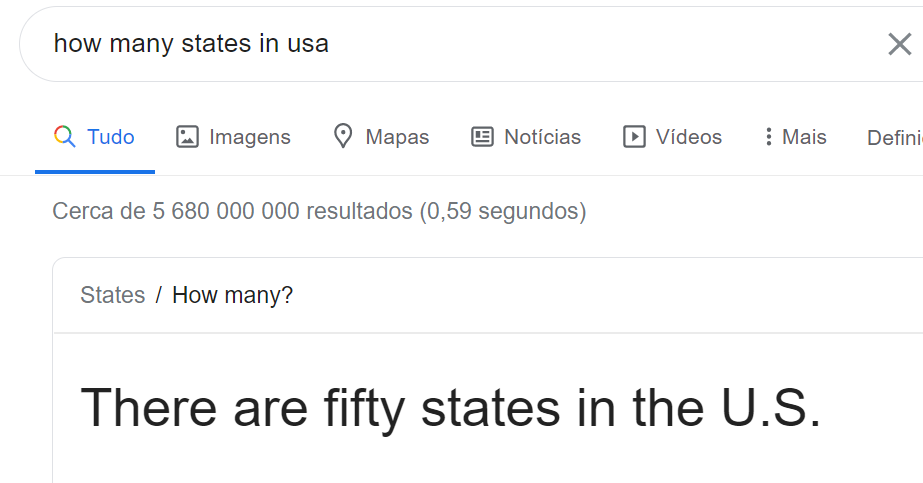

In [ ]:
# There are more values for the states than the number of states that google states exist indeed 
len(users_data["STATE"].unique()) #57 states identified in our dataset

#Let's try to see the values to check what is wrong :
users_data["STATE"].unique()

# We googled and found an array with the initials of the states and Washington DC, which isn't exactly a state but due to its importance its many times counted as such:
states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA", 
          "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
          "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
          "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
          "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]

# Now let's compare the values that were in the States list with the values in our dataset, and see which values are different:
users_data["STATE"].loc[(~users_data["STATE"].isin(states))].value_counts()

# (https://en.wikipedia.org/wiki/List_of_U.S._state_and_territory_abbreviations)

# AP, AA and AE are US Military Mail Codes
# VI stands for Virgin Islands
# GU stands for Guam, an island in the pacific
# AS is from American Samoa
# These values are called "USA Territories" and not exactly states. We should consider renaming the variable for more accurate results

###### **Income Analysis**

In [ ]:
users_data[['WEALTH1', "WEALTH2", "INCOME"]].isna().sum()

In [ ]:
(users_data[users_data['WEALTH1'].isna() & users_data['WEALTH2'].isna()].shape[0]) / users_data.shape[0]

As we can see both wealth variables have a lot of missing values, however if we combine both, we will have 22% of observations which will need their values imputed.

- *WEALTH1* is prefered to *WEALTH2*, since *WEALTH2* is dependent on the donors state, so when we have observations with values in both, we would prefer the WEALTH1 value. We know this isn't ideal but it is better than imputing an estimated value.

- However, *WEALTH2* represents the median family income, and the metadata isn't really clear about what does *WEALTH1* refere to.

- The variable *INCOME* is interpreted as representing the total family income of each donor. The metadata isn't clear about it, but we believe it has a different bin distribuition, since it only has values between 1 and 7.

In [ ]:
(users_data[users_data['WEALTH1'].isna() & users_data['WEALTH2'].isna() & users_data['INCOME'].isna()].shape[0]) / users_data.shape[0]

If we also combine *INCOME* we will have 11% of missing values, but unfortunently, since they seem to show different bins, this isn't doable.

So let's see how many values are different between *WEALTH1* and *WEALTH2*.

In [ ]:
(users_data[['WEALTH1', 'WEALTH2']][(users_data['WEALTH1'] != users_data['WEALTH2'])
                                  & (~(users_data['WEALTH1'].isna())) & (~(users_data['WEALTH2'].isna()))
                                  ].shape[0] /users_data.shape[0]) * 100

#10% of data points have different values of WEALTH1 and 2

But this percentage doesn't tell us how big is the difference between the values.

In [ ]:
#Avg difference between different values of WEALTH1 and WEALTH2

(((users_data['WEALTH1'][(users_data['WEALTH1'] != users_data['WEALTH2'])
                                  & (~(users_data['WEALTH1'].isna())) & (~(users_data['WEALTH2'].isna()))] - users_data['WEALTH2'][(users_data['WEALTH1'] != users_data['WEALTH2'])
                                  & (~(users_data['WEALTH1'].isna())) & (~(users_data['WEALTH2'].isna()))])**2)**(1/2)).mean()

In [ ]:
#Std difference between different values of WEALTH1 and WEALTH2

(((users_data['WEALTH1'][(users_data['WEALTH1'] != users_data['WEALTH2'])
                                  & (~(users_data['WEALTH1'].isna())) & (~(users_data['WEALTH2'].isna()))] - users_data['WEALTH2'][(users_data['WEALTH1'] != users_data['WEALTH2'])
                                  & (~(users_data['WEALTH1'].isna())) & (~(users_data['WEALTH2'].isna()))])**2)**(1/2)).std()

As we can see, when there is a difference between *WEALTH1*and *WEALTH2*, it is quite big (about more than one bin).

In [ ]:
(users_data[users_data['INCOME'].isna()].shape[0] / users_data.shape[0]) * 100

If we use the variable *INCOME* we will have about 22% missing values, the same as the combination of *WEALTH1* and *WEALTH2*, and we don't have to combine any variables or take in to account assumptions we don't believe to be very strong.

So if we want to cluster having into account the income of the donors, we will use the total family income of each

In [ ]:
users_data.drop(columns = ['WEALTH1', 'WEALTH2'], inplace = True)

###### **Variable Transformation**

In [ ]:
#We will turn the following variables into binary ones:

empty_space_Value_to_binary(users_data, "MAILCODE", 'B')
empty_space_Value_to_binary(users_data, "PVASTATE", 'P')
empty_space_Value_to_binary(users_data, "HOMEOWNR", 'H')
empty_space_Value_to_binary(users_data, 'MAJOR', 'X') 

for column in ['COLLECT1', 'VETERANS', 'BIBLE', 'CATLG', 'HOMEE', 'PETS', 'CDPLAY','STEREO', 'PCOWNERS', 'PHOTO', 'CRAFTS', 'FISHER', 'GARDENIN', 'BOATS','WALKER', 'KIDSTUFF', 'CARDS', 'PLATES']:
  empty_space_Value_to_binary(users_data, column, 'Y')

users_data["PVASTATE"] = users_data["PVASTATE"].map(lambda x: 0 if x == 'E' else x)
users_data["HOMEOWNR"] = users_data["HOMEOWNR"].map(lambda x: 0 if x == 'U' else x)

users_data["PVASTATE"] = users_data["PVASTATE"].astype("int64")
users_data["HOMEOWNR"] = users_data["HOMEOWNR"].astype("int64")


#As the values of MAILCODE reference a bad adress, we will rename the column to mean so:
users_data.rename(columns={"MAILCODE": "WRONG_ADRESS"}, inplace=True)


#We can see that there are 1399 people that have no valid address, which is problematic since the gifts and promotions are sent by mail
users_data["WRONG_ADRESS"].value_counts() #1 - 1399

#Put the following columns as binary. Special care had to be done to the variable NOEXCH which didnt have the values it should, and had values as strings and as ints. 
#so the approach was to change everything to string and then to int, to be able to have a proper binary variable
for i in ["NOEXCH", "RECINHSE","RECP3","RECPGVG","RECSWEEP","PEPSTRFL"]:
    empty_space_Value_to_binary(users_data, i, 'X')

users_data["NOEXCH"] = users_data["NOEXCH"].astype('str')
users_data["NOEXCH"] = users_data["NOEXCH"].astype('int64')

# Make the Variable Gender, Binary:
gender_treatment(users_data, "GENDER")

#Use the function that automatically searches for the correct datetime to put our date variables in the right format:
for i in ["DOB","ODATEDW"]:
    from_object_to_datetime(users_data, i)

#Some values had a strange "-" in the end which did not allow the variable to be numeric:
users_data["ZIP"] = users_data["ZIP"].str.replace('-', '') .astype("int64")

#In this line we will put the null values that were formatted as " " in a proper format:
users_data[["CHILD03", "CHILD07", "CHILD12", "CHILD18", "GEOCODE2"]]= users_data[["CHILD03", "CHILD07", "CHILD12", "CHILD18","GEOCODE2"]].replace(" ", np.nan)

#Put the unreadable values that were as "XXXX" in a proper format:
users_data["MDMAUD"] = users_data["MDMAUD"].replace("XXXX", np.nan)

#We will divide the variable in GENDER in one that represents gender, and another one that represents the information in a Joint account
users_data['JOINT'] = np.where(users_data['GENDER']=='J', 1,0)
users_data['GENDER'] = users_data['GENDER'].replace(['J'], np.nan) #Change the values of joint acounts to unknown
users_data['FEMALE'] = users_data['GENDER'].map(lambda x: 1 if x == 'F' else 0 ) #And now we can create the variable female


#Let's turn the date of birth to a more readable variable: age of the referenced person in years, accourding to the referenced date of the dataset.
rfa['ADATE_2'].unique() #as we can see, the current date is 2017, so we will use this data as the current date
users_data['AGE'] = users_data['DOB'].apply(lambda x : (2017 - x.year))

#The variable NUMCHLD has missing values. We decided to check whether the variable had 0s or not, and given that it doesn't, 
#we will make the assumption that a missing value means that the person does not have a child and not the lack of information about the matter.
users_data["NUMCHLD"].value_counts() #minimum 0 kids, and maximum 7

users_data["NUMCHLD"] = users_data["NUMCHLD"].replace(np.nan, 0)
users_data["DOMAIN"] = users_data["DOMAIN"].map(lambda x: np.nan if x ==" " else x)

users_data["URBANICITY"] = users_data["DOMAIN"].str[0:1]
users_data["SES"] = users_data["DOMAIN"].str[1:2]
users_data["SES"] = users_data["SES"].astype("float64")

for value in range(0,users_data.shape[0]):
  if users_data["URBANICITY"][value] == 'U':
    if users_data["SES"][value] ==3:
      users_data["SES"][value] =2
    if users_data["SES"][value] ==4:
      users_data["SES"][value] =3

# We are going to drop the following variables:
# -CHILD03, CHILD07, CHILD12, CHILD18: the variables have 98.8% of missing values and are not easy to interpret or put in a numeric format.
# -TCODE: brings no information to the model. meaning, its impossible to encode and to even identify patterns with it.
# -OSOURCE: No information is provided for us to be able to interpret the variables
# -GENDER: We are going to drop this column because we have put its information in a more structured variable, FEMALE
# -DOMAIN: We are going to drop this column because we have put its information in 2 other variables, URBANICITY, SES
# -MDMAUD: We will remove this variable as its values are already decomposed later in the dataset and we don't want to have duplicate information

users_data= users_data.drop(columns = ["CHILD03", "CHILD07", "CHILD12", "CHILD18", "MDMAUD", "TCODE", "OSOURCE", "GENDER", "MDMAUD", "DOMAIN", "DOB"])

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
metric_features = users_data.select_dtypes(include=numerics)

###### **Encoding & Imputing Missing Values**

In [ ]:
categorical = ['object']
categorical_features = users_data.select_dtypes(include=categorical)
# create object of Ordinalencoding
encoder= ce.OrdinalEncoder(cols=['URBANICITY'],return_df=True, mapping=[{'col':'URBANICITY','mapping':{'R':0,'T':1,'S':2,'C':3,'U':4}}])
#fit and transform train data 
users_data = encoder.fit_transform(users_data)
users_data["URBANICITY"] = users_data["URBANICITY"].replace(-1,np.nan)

In [ ]:
missing_zero_values_table(users_data)

In [ ]:
#We decided to postpone the idea of imputing missing values in the variables that have information about the mailing promotions that the donors have responded to. 
#So, we will proceed on doing the missing value imputation of the variables *AGE*, *INCOME*, *URBANICITY*, *SES*, *GEOCODE2*

metric_features2 = ["NUMCHLD", "HIT", "MALEVET", 'VIETVETS', 'WWIIVETS', 'LOCALGOV', 'FEDGOV','AGE']

# Age - KNN Imputer
imputer = KNNImputer(n_neighbors=5, weights="uniform")
users_data[metric_features2] = imputer.fit_transform(users_data[metric_features2])

# users_data["GEOCODE2"]= users_data["GEOCODE2"].fillna(users_data["GEOCODE2"].mode()[0])
# users_data["URBANICITY"]= users_data["URBANICITY"].fillna(users_data["URBANICITY"].mode()[0])
# users_data["SES"]= users_data["SES"].fillna(users_data["SES"].mode()[0])
# users_data["INCOME"]= users_data["INCOME"].fillna(users_data["INCOME"].mode()[0])

###### **Coherence Checks and Outliers**

In [ ]:
#COHERENCE CHECKS

#Variable TOTGIFT_NAN represents the number of times a donor responded to other mail offers, from the ones we have information of.
#If the value of HIT, wich is the number of times a donor responded to mail offers than pva, is smaller than the value of this variable we created, we replace the HIT value.

users_data["TOTGIFT_NAN"]= users_data[['MBCRAFT', 'MBGARDEN', 'MBBOOKS', 'MBCOLECT', 'MAGFAML', 'MAGFEM', 'MAGMALE', 'PUBGARDN', 'PUBCULIN', 'PUBHLTH', 'PUBDOITY', 'PUBNEWFN', 'PUBPHOTO', 'PUBOPP']].sum(axis=1,  min_count=1)
users_data[["HIT", "TOTGIFT_NAN"]].loc[users_data["HIT"] < users_data["TOTGIFT_NAN"]]
users_data["HIT"][users_data["HIT"] < users_data["TOTGIFT_NAN"]] = users_data["TOTGIFT_NAN"][users_data["HIT"] < users_data["TOTGIFT_NAN"]] 
users_data[["HIT", "TOTGIFT_NAN"]].loc[users_data["HIT"] < users_data["TOTGIFT_NAN"]]

users_data_outliers = users_data[["NUMCHLD", "HIT", "MALEVET", 'VIETVETS', 'WWIIVETS', 'LOCALGOV', 'FEDGOV','AGE']]
hist_box_maker(users_data_outliers, "Users Data Value Distribution", users_data_outliers.shape[1], 20,20)


In [ ]:
#We will delete about 0.3% of our data with these outlier removal:
print(users_data[(users_data['FEDGOV']>55)|(users_data['LOCALGOV']>43)|(users_data['MALEMILI']>63)|(users_data['MALEVET']>87)|(users_data['STATEGOV']>63)|(users_data['VIETVETS']>95)].shape[0] / users_data.shape[0])
users_data = users_data[~((users_data['FEDGOV']>55)|(users_data['LOCALGOV']>43)|(users_data['MALEMILI']>63)|(users_data['MALEVET']>87)|(users_data['STATEGOV']>63)|(users_data['VIETVETS']>95))]

###### **Correlation Matrix**

In [ ]:
metric_features = corr_df(metric_features, 0.85)

In [ ]:
users_data = users_data.drop(columns = ['RECSWEEP'])

In [ ]:
users_data["ALL_VETS"] = users_data[["MALEMILI", "MALEVET"]].sum(axis=1)

### RFA

In [ ]:
#First we will combine both dataframes due to the previously droped observations.

rfa = pd.concat([rfa, users_data], join='inner', axis=1)[rfa.columns.to_list()]
#Concats both dataframes, inner join due to observations already eliminated, axis 1 to concat on columns, rfa.columns to only select the need columns

# When it comes to the promotions sent and gifts received, we can divide the data in to 6 groups.

#-ADATE_X's,
#-RFA_X's,
#-Aggregations or derivates of the above two groups,
#-RDATE_X's,
#-RAMNT_X's,
#-Aggregations or derivates of the above two groups. Let's first take care of the aggregations or derivatives variables, 
#as these will probably be the ones we will work with the most, since the other ones are to specific, which is great to do some coherence checks or create other variables, but not to cluster with.

In [ ]:
#Typecast all of the date variables to their correct dtype
for i in ['ADATE_2', 'ADATE_3', 'ADATE_4', 'ADATE_5', 'ADATE_6', 'ADATE_7',
       'ADATE_8', 'ADATE_9', 'ADATE_10', 'ADATE_11', 'ADATE_12', 'ADATE_13',
       'ADATE_14', 'ADATE_15', 'ADATE_16', 'ADATE_17', 'ADATE_18', 'ADATE_19',
       'ADATE_20', 'ADATE_21', 'ADATE_22', 'ADATE_23', 'ADATE_24', "MAXADATE", 'RDATE_3', 'RDATE_4', 'RDATE_5', 'RDATE_6', 'RDATE_7', 'RDATE_8',
       'RDATE_9', 'RDATE_10', 'RDATE_11', 'RDATE_12', 'RDATE_13', 'RDATE_14',
       'RDATE_15', 'RDATE_16', 'RDATE_17', 'RDATE_18', 'RDATE_19', 'RDATE_20',
       'RDATE_21', 'RDATE_22', 'RDATE_23', 'RDATE_24', "MINRDATE", "MAXRDATE", "LASTDATE", "FISTDATE", "NEXTDATE"]:
    rfa[i] =  pd.to_datetime(rfa[i], infer_datetime_format=True)

In [ ]:
#Coherence 1: the type number of promotions received in the last 12 months being higher than in the lifetime.
rfa[(rfa['CARDPROM'] < rfa['CARDPM12']) | (rfa['NUMPROM'] < rfa['NUMPRM12'])].shape[0]

In [ ]:
# Nothing seems out of the ordinary, looking at the mean, std and min and max values maybe some outliers, but we will check this better later.
rfa[['CARDPROM', 'MAXADATE', 'NUMPROM', 'CARDPM12', 'NUMPRM12']].describe() # Most important thing is that there are no negative values
rfa[['CARDPROM', 'MAXADATE', 'NUMPROM', 'CARDPM12', 'NUMPRM12']].dtypes # All of the types are correct

#All of the dtypes seem to be correct except the TIMELAG one, it should be int since the variable corresponds to the number of months between the first and second gift
rfa[['RAMNTALL', 'NGIFTALL', 'CARDGIFT', 'MINRAMNT', 'MINRDATE', 'MAXRAMNT', 'MAXRDATE', 'LASTGIFT', 'LASTDATE', 'FISTDATE', 'NEXTDATE', 'TIMELAG', 'AVGGIFT']].head()

#There are floats because of missing values. But are these actual missing values or observations where a donor simply gave just one gift?
rfa[['RAMNTALL', 'NGIFTALL', 'CARDGIFT', 'MINRAMNT', 'MINRDATE', 'MAXRAMNT', 'MAXRDATE', 'LASTGIFT', 'LASTDATE', 'FISTDATE', 'NEXTDATE', 'TIMELAG', 'AVGGIFT']].dtypes

rfa['TIMELAG'].isna().sum() #9910 As we can see all of the TIMELAG missing values are observations where a donor simply gave on gift.
#So we can't just impute these missing values, we have to change them into something if we want to use this variable.

In [ ]:
#Coherence 2: However there are some observations where only one gift was donated but a value for TIMELAG exists
rfa[(rfa['TIMELAG'].isna()) & (rfa['NGIFTALL'] == 1)].shape[0]

In [ ]:
#Coherence 3:When this value is zero, this means that just one donation was made but there is a value for NEXTDATE and it is the same as the FISTDATE. We could leave them ,
#we just have to be carefull when interpreting zeros in this variable, as they can mean both someone who just donated once or someone who made the first two donations 
#on the same day.
#If we leave these two interpretations open we can also change the missing values of TIMELAG, wich all correspond to someone who made just one gift, to zero.
# Or we can delete all of these observations, making sure that there isn't any possibility of a wrong assumption being made.

#The bigger problem is when someone made just one donation but the TIMELAG isn't zero. These values for sure need to be deleted.

rfa[rfa['NGIFTALL'] == 1 & ~(rfa['TIMELAG'].isna())].shape[0]

In [ ]:
#Coherence 4: Since there are so few values that have this problem we will just delete all of them to be sure we aren't doing any assumption that jeopardizes our analysis.
(rfa['TIMELAG'][rfa['NGIFTALL'] == 1 & ~(rfa['TIMELAG'].isna())] == 0).value_counts()

In [ ]:
#Coherence 5:There are also some observations were the TIMELAG is zero but more than one gift was given.
rfa = rfa[~(rfa['NGIFTALL'] == 1 & ~(rfa['TIMELAG'].isna()))]

In [ ]:
#Coherence 6: There are now 895 observations were supposedly the first gift was given in the same date as the second.
rfa[(rfa['TIMELAG'] == 0) & (rfa['NGIFTALL'] > 1)].shape[0]

In [ ]:
#Coherence 7: And all of these dates have a TIMELAG of zero.
#So we can assume that all of the observations were a donor gave more than one gift but the TIMELAG is zero are correct values,
#as at least the first and second gift could be given on the same day.
rfa[(rfa['FISTDATE'] == rfa['NEXTDATE']) & (rfa['TIMELAG'] == 0)].shape[0]

#All of the other variables don't have any missing values, except FISTDATE, wich we will take care of later.

In [ ]:
# Coherence 8:And no incoherences seem to exist, at least of the type total number of promotions received being smaller than total number of card promotions, 
#date of the first gift being more recent than date of the second gift and smallest donation done being more expensive than highest donation.
# And through the describe function we can see that there are no weird negative values, and that some outlier detection migth be needed.

rfa[['RAMNTALL', 'NGIFTALL', 'CARDGIFT', 'MINRAMNT', 'MINRDATE', 'MAXRAMNT', 'MAXRDATE', 'LASTGIFT', 'LASTDATE', 'FISTDATE', 'NEXTDATE', 'TIMELAG', 'AVGGIFT']].isna().sum()
rfa[['RAMNTALL', 'NGIFTALL', 'CARDGIFT', 'MINRAMNT', 'MINRDATE', 'MAXRAMNT', 'MAXRDATE', 'LASTGIFT', 'LASTDATE', 'FISTDATE', 'NEXTDATE', 'TIMELAG', 'AVGGIFT']].describe().T
rfa[(rfa['NGIFTALL'] < rfa['CARDGIFT']) | (rfa['FISTDATE'] > rfa['NEXTDATE']) | (rfa['MINRAMNT'] > rfa['MAXRAMNT'])].shape[0] #0

In [ ]:
# As we can see both observations with missing values on FISTDATE have given a lot of gifts, have both values of the second gift 
# given and have a clearly wrong value for TIMELAG. 1044 months is equivelent to 87 years, so it is safe to assume that we can drop these two records.
rfa[['NGIFTALL', 'NEXTDATE', 'TIMELAG']][rfa['FISTDATE'].isna()]

In [ ]:
#FISTDATE and ODATEDW supposedly have the same information, however in most observations this isn't the case, possibly due to the source of this variables being different.
#Since we are not going to use directly any of this variables, and FISTDATE comes from the same source as all of the corresponding promotion and gifts variables, 
#we will drop ODATEDW. Even though we wil also later drop or not use FISTDATE.
rfa = rfa[~(rfa['FISTDATE'].isna())]
rfa['FISTDATE'].isna().sum()
users_data['ODATEDW'].isna().sum()

In [ ]:
users_data['ODATEDW'] = pd.to_datetime(users_data['ODATEDW'], infer_datetime_format=True)

In [ ]:
#Since we already droped some observations, once again we have to remove those observations from users_data
users_data = pd.concat([rfa, users_data], join='inner', axis=1)[users_data.columns.to_list()]

In [ ]:
(users_data['ODATEDW'] != rfa['FISTDATE']).sum()

In [ ]:
users_data.drop(columns = ['ODATEDW'], inplace = True)

In [ ]:
# Lastly we can see if the timelag value is correct.
#And as we can see it is.
((((rfa['NEXTDATE'].apply(lambda x: x.year) - rfa['FISTDATE'].apply(lambda x: x.year)) * 12 + rfa['NEXTDATE'].apply(lambda x: x.month) - rfa['FISTDATE'].apply(lambda x: x.month)) != rfa['TIMELAG']) & ~(rfa['TIMELAG'].isna()) & ~(rfa['NEXTDATE'].isna()) & ~(rfa['FISTDATE'].isna())).value_counts()

**ADATE_X, RDATE_X and LASTDATE Treatment**

In [ ]:
# As we can see we have a lot of missing values in most of these variables., which most likely correspond to promotions or gifts that werent sent.
rfa[['ADATE_2', 'ADATE_3', 'ADATE_4', 'ADATE_5', 'ADATE_6', 'ADATE_7',
       'ADATE_8', 'ADATE_9', 'ADATE_10', 'ADATE_11', 'ADATE_12', 'ADATE_13',
       'ADATE_14', 'ADATE_15', 'ADATE_16', 'ADATE_17', 'ADATE_18', 'ADATE_19',
       'ADATE_20', 'ADATE_21', 'ADATE_22', 'ADATE_23', 'ADATE_24', 'RDATE_3', 'RDATE_4', 'RDATE_5', 'RDATE_6', 'RDATE_7', 'RDATE_8',
       'RDATE_9', 'RDATE_10', 'RDATE_11', 'RDATE_12', 'RDATE_13', 'RDATE_14',
       'RDATE_15', 'RDATE_16', 'RDATE_17', 'RDATE_18', 'RDATE_19', 'RDATE_20',
       'RDATE_21', 'RDATE_22', 'RDATE_23', 'RDATE_24']].isna().sum()

We can check wether there are any observations were the LASTDATE isn't more recent than RDATE_X.

In [ ]:
#Coherence 9:We can check whether there are any observations were the LASTDATE isn't more recent than RDATE_X.
(rfa[(rfa['LASTDATE'] < rfa['RDATE_3']) |
     (rfa['LASTDATE'] < rfa['RDATE_4']) |
     (rfa['LASTDATE'] < rfa['RDATE_5']) |
     (rfa['LASTDATE'] < rfa['RDATE_6']) |
     (rfa['LASTDATE'] < rfa['RDATE_7']) |
     (rfa['LASTDATE'] < rfa['RDATE_8']) |
     (rfa['LASTDATE'] < rfa['RDATE_9']) |
     (rfa['LASTDATE'] < rfa['RDATE_10']) |
     (rfa['LASTDATE'] < rfa['RDATE_11']) |
     (rfa['LASTDATE'] < rfa['RDATE_12']) |
     (rfa['LASTDATE'] < rfa['RDATE_13']) |
     (rfa['LASTDATE'] < rfa['RDATE_14']) |
     (rfa['LASTDATE'] < rfa['RDATE_15']) |
     (rfa['LASTDATE'] < rfa['RDATE_16']) |
     (rfa['LASTDATE'] < rfa['RDATE_17']) |
     (rfa['LASTDATE'] < rfa['RDATE_18']) |
     (rfa['LASTDATE'] < rfa['RDATE_19']) |
     (rfa['LASTDATE'] < rfa['RDATE_20']) |
     (rfa['LASTDATE'] < rfa['RDATE_21']) |
     (rfa['LASTDATE'] < rfa['RDATE_22']) |
     (rfa['LASTDATE'] < rfa['RDATE_23']) |
     (rfa['LASTDATE'] < rfa['RDATE_24']) ].shape[0] / rfa.shape[0]) * 100

# Only 0.08% of observations have this problem, we can just change the value of LASTDATE, guarantying that this is infact the last known date a donor gave a gift.

In [ ]:
#Coherence 10: In theory, the LASTDATE should be one of the values of RDATE_X, however for 13% of observations this isn't the case. 
#But there is always the possibility that the last gift didn't correspond to any of the promotions we have on our dataset.
#Since there are so many observations where this happens, we think the problem is in our initial assumption and not on the data itself.

rfa['LASTDATE'][(rfa['LASTDATE'] < rfa['RDATE_3']) |
     (rfa['LASTDATE'] < rfa['RDATE_4']) |
     (rfa['LASTDATE'] < rfa['RDATE_5']) |
     (rfa['LASTDATE'] < rfa['RDATE_6']) |
     (rfa['LASTDATE'] < rfa['RDATE_7']) |
     (rfa['LASTDATE'] < rfa['RDATE_8']) |
     (rfa['LASTDATE'] < rfa['RDATE_9']) |
     (rfa['LASTDATE'] < rfa['RDATE_10']) |
     (rfa['LASTDATE'] < rfa['RDATE_11']) |
     (rfa['LASTDATE'] < rfa['RDATE_12']) |
     (rfa['LASTDATE'] < rfa['RDATE_13']) |
     (rfa['LASTDATE'] < rfa['RDATE_14']) |
     (rfa['LASTDATE'] < rfa['RDATE_15']) |
     (rfa['LASTDATE'] < rfa['RDATE_16']) |
     (rfa['LASTDATE'] < rfa['RDATE_17']) |
     (rfa['LASTDATE'] < rfa['RDATE_18']) |
     (rfa['LASTDATE'] < rfa['RDATE_19']) |
     (rfa['LASTDATE'] < rfa['RDATE_20']) |
     (rfa['LASTDATE'] < rfa['RDATE_21']) |
     (rfa['LASTDATE'] < rfa['RDATE_22']) |
     (rfa['LASTDATE'] < rfa['RDATE_23']) |
     (rfa['LASTDATE'] < rfa['RDATE_24']) ] = rfa[['RDATE_3', 'RDATE_4', 'RDATE_5', 'RDATE_6', 'RDATE_7', 'RDATE_8',
                                                  'RDATE_9', 'RDATE_10', 'RDATE_11', 'RDATE_12', 'RDATE_13', 'RDATE_14', 'RDATE_15', 'RDATE_16', 'RDATE_17', 'RDATE_18', 'RDATE_19', 'RDATE_20', 'RDATE_21', 'RDATE_22', 'RDATE_23', 'RDATE_24']][
    (rfa['LASTDATE'] < rfa['RDATE_3']) |
     (rfa['LASTDATE'] < rfa['RDATE_4']) |
     (rfa['LASTDATE'] < rfa['RDATE_5']) |
     (rfa['LASTDATE'] < rfa['RDATE_6']) |
     (rfa['LASTDATE'] < rfa['RDATE_7']) |
     (rfa['LASTDATE'] < rfa['RDATE_8']) |
     (rfa['LASTDATE'] < rfa['RDATE_9']) |
     (rfa['LASTDATE'] < rfa['RDATE_10']) |
     (rfa['LASTDATE'] < rfa['RDATE_11']) |
     (rfa['LASTDATE'] < rfa['RDATE_12']) |
     (rfa['LASTDATE'] < rfa['RDATE_13']) |
     (rfa['LASTDATE'] < rfa['RDATE_14']) |
     (rfa['LASTDATE'] < rfa['RDATE_15']) |
     (rfa['LASTDATE'] < rfa['RDATE_16']) |
     (rfa['LASTDATE'] < rfa['RDATE_17']) |
     (rfa['LASTDATE'] < rfa['RDATE_18']) |
     (rfa['LASTDATE'] < rfa['RDATE_19']) |
     (rfa['LASTDATE'] < rfa['RDATE_20']) |
     (rfa['LASTDATE'] < rfa['RDATE_21']) |
     (rfa['LASTDATE'] < rfa['RDATE_22']) |
     (rfa['LASTDATE'] < rfa['RDATE_23']) |
     (rfa['LASTDATE'] < rfa['RDATE_24']) ].max(axis = 1)

In [ ]:
(rfa[(rfa['LASTDATE'] != rfa['RDATE_3']) &
     (rfa['LASTDATE'] != rfa['RDATE_4']) &
     (rfa['LASTDATE'] != rfa['RDATE_5']) &
     (rfa['LASTDATE'] != rfa['RDATE_6']) &
     (rfa['LASTDATE'] != rfa['RDATE_7']) &
     (rfa['LASTDATE'] != rfa['RDATE_8']) &
     (rfa['LASTDATE'] != rfa['RDATE_9']) &
     (rfa['LASTDATE'] != rfa['RDATE_10']) &
     (rfa['LASTDATE'] != rfa['RDATE_11']) &
     (rfa['LASTDATE'] != rfa['RDATE_12']) &
     (rfa['LASTDATE'] != rfa['RDATE_13']) &
     (rfa['LASTDATE'] != rfa['RDATE_14']) &
     (rfa['LASTDATE'] != rfa['RDATE_15']) &
     (rfa['LASTDATE'] != rfa['RDATE_16']) &
     (rfa['LASTDATE'] != rfa['RDATE_17']) &
     (rfa['LASTDATE'] != rfa['RDATE_18']) &
     (rfa['LASTDATE'] != rfa['RDATE_19']) &
     (rfa['LASTDATE'] != rfa['RDATE_20']) &
     (rfa['LASTDATE'] != rfa['RDATE_21']) &
     (rfa['LASTDATE'] != rfa['RDATE_22']) &
     (rfa['LASTDATE'] != rfa['RDATE_23']) &
     (rfa['LASTDATE'] != rfa['RDATE_24']) ].shape[0] / rfa.shape[0]) * 100

It doesn't make sense for a donor to give a gift regarding a promotion he hasn't received yet.

In [ ]:
#Coherence 11: It doesn't make sense for a donor to give a gift regarding a promotion he hasn't received yet.
(rfa[(rfa['RDATE_3'] < rfa['ADATE_3']) |
     (rfa['RDATE_4'] < rfa['ADATE_4']) |
     (rfa['RDATE_5'] < rfa['ADATE_5']) |
     (rfa['RDATE_6'] < rfa['ADATE_6']) |
     (rfa['RDATE_7'] < rfa['ADATE_7']) |
     (rfa['RDATE_8'] < rfa['ADATE_8']) |
     (rfa['RDATE_9'] < rfa['ADATE_9']) |
     (rfa['RDATE_10'] < rfa['ADATE_10']) |
     (rfa['RDATE_11'] < rfa['ADATE_11']) |
     (rfa['RDATE_12'] < rfa['ADATE_12']) |
     (rfa['RDATE_13'] < rfa['ADATE_13']) |
     (rfa['RDATE_14'] < rfa['ADATE_14']) |
     (rfa['RDATE_15'] < rfa['ADATE_15']) |
     (rfa['RDATE_16'] < rfa['ADATE_16']) |
     (rfa['RDATE_17'] < rfa['ADATE_17']) |
     (rfa['RDATE_18'] < rfa['ADATE_18']) |
     (rfa['RDATE_19'] < rfa['ADATE_19']) |
     (rfa['RDATE_20'] < rfa['ADATE_20']) |
     (rfa['RDATE_21'] < rfa['ADATE_21']) |
     (rfa['RDATE_22'] < rfa['ADATE_22']) |
     (rfa['RDATE_23'] < rfa['ADATE_23']) |
     (rfa['RDATE_24'] < rfa['ADATE_24']) ].shape[0] / rfa.shape[0]) * 100

     #0.8% of data points have this issue, but since the problem is in this specific variables and we won't use them, we believe there is no need to drop these observations.

**RFA_x and RAMNT_X Treatment**

In [ ]:
# All variables have the correct dtype.
# No negative values, some outliers for sure,
# but if we are not going to use these variables, since the outliers seem to be correct values, just extreme, there is no point in removing the records.
# There is one record where the value of the smallest donation is higher than one of the gifts given in one of the various promotions and 23 records 
# were the highest donation is smaller than one of the gifts of the various promotions. So we will correct these values.

rfa[['RAMNT_3', 'RAMNT_4', 'RAMNT_5', 'RAMNT_6', 'RAMNT_7', 'RAMNT_8', 'RAMNT_9', 'RAMNT_10', 'RAMNT_11', 'RAMNT_12', 'RAMNT_13', 'RAMNT_14', 'RAMNT_15', 'RAMNT_16', 'RAMNT_17', 'RAMNT_18', 'RAMNT_19', 'RAMNT_20', 'RAMNT_21', 'RAMNT_22', 'RAMNT_23', 'RAMNT_24']].dtypes

In [ ]:
rfa[(rfa['MINRAMNT'] > rfa['RAMNT_3']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_4']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_5']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_6']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_7']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_8']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_9']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_10']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_11']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_12']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_13']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_14']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_15']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_16']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_17']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_18']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_19']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_20']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_21']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_22']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_23']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_24'])].shape[0]

In [ ]:
rfa['MINRAMNT'][(rfa['MINRAMNT'] > rfa['RAMNT_3']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_4']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_5']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_6']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_7']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_8']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_9']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_10']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_11']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_12']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_13']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_14']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_15']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_16']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_17']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_18']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_19']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_20']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_21']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_22']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_23']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_24'])] = rfa[['RAMNT_3', 'RAMNT_4', 'RAMNT_5', 'RAMNT_6', 'RAMNT_7', 'RAMNT_8', 'RAMNT_9', 'RAMNT_10', 'RAMNT_11', 'RAMNT_12', 'RAMNT_13', 'RAMNT_14', 'RAMNT_15', 'RAMNT_16', 'RAMNT_17', 'RAMNT_18', 'RAMNT_19', 'RAMNT_20', 'RAMNT_21', 'RAMNT_22', 'RAMNT_23', 'RAMNT_24']][(rfa['MINRAMNT'] > rfa['RAMNT_3']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_4']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_5']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_6']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_7']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_8']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_9']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_10']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_11']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_12']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_13']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_14']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_15']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_16']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_17']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_18']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_19']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_20']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_21']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_22']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_23']) |
    (rfa['MINRAMNT'] > rfa['RAMNT_24'])].min(axis=1)

In [ ]:
rfa[(rfa['MAXRAMNT'] < rfa['RAMNT_3']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_4']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_5']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_6']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_7']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_8']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_9']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_10']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_11']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_12']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_13']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_14']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_15']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_16']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_17']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_18']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_19']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_20']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_21']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_22']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_23']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_24'])].shape[0]

In [ ]:
rfa['MAXRAMNT'][(rfa['MAXRAMNT'] < rfa['RAMNT_3']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_4']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_5']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_6']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_7']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_8']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_9']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_10']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_11']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_12']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_13']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_14']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_15']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_16']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_17']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_18']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_19']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_20']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_21']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_22']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_23']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_24'])] = rfa[['RAMNT_3', 'RAMNT_4', 'RAMNT_5', 'RAMNT_6', 'RAMNT_7', 'RAMNT_8', 'RAMNT_9', 'RAMNT_10', 'RAMNT_11', 'RAMNT_12', 'RAMNT_13', 'RAMNT_14', 'RAMNT_15', 'RAMNT_16', 'RAMNT_17', 'RAMNT_18', 'RAMNT_19', 'RAMNT_20', 'RAMNT_21', 'RAMNT_22', 'RAMNT_23', 'RAMNT_24']][(rfa['MAXRAMNT'] < rfa['RAMNT_3']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_4']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_5']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_6']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_7']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_8']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_9']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_10']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_11']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_12']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_13']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_14']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_15']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_16']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_17']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_18']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_19']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_20']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_21']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_22']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_23']) |
    (rfa['MAXRAMNT'] < rfa['RAMNT_24'])].max(axis=1)

In [ ]:
# Lets sum all of the values of all the gifts given, and check whether the total dollar amount of gifts given is smaller than this.
# A smaller value of total dollar amount of gifts given regarding the promotions than RAMNTALL is comprehensible, 
# other donations regarding different promotions migth have been given, however a higher value is clearly wrong, we will change the value of these observations.
rfa['TOTL_GIFTS_AMOUNT'] = rfa[['RAMNT_3', 'RAMNT_4', 'RAMNT_5', 'RAMNT_6', 'RAMNT_7', 'RAMNT_8', 'RAMNT_9', 'RAMNT_10', 'RAMNT_11', 'RAMNT_12', 'RAMNT_13', 'RAMNT_14', 'RAMNT_15', 'RAMNT_16', 'RAMNT_17', 'RAMNT_18', 'RAMNT_19', 'RAMNT_20', 'RAMNT_21', 'RAMNT_22', 'RAMNT_23', 'RAMNT_24']].sum(axis = 1)

In [ ]:
(rfa['TOTL_GIFTS_AMOUNT'] > rfa['RAMNTALL']).sum()

In [ ]:
rfa['RAMNTALL'][(rfa['TOTL_GIFTS_AMOUNT'] > rfa['RAMNTALL'])] = rfa['TOTL_GIFTS_AMOUNT'][(rfa['TOTL_GIFTS_AMOUNT'] > rfa['RAMNTALL'])]

We have the total amount of donations given, but we can also calculate the total amount of card donations given.

Card donations being the ones of the promotions FS, GK, TK, SK, NK, XK, UF, UU, just like defined on the metadata.

And the total amount of notepad donations, X1, G1.

And promotions with only labels or stickers, LL, WL, CC.

In [ ]:
rfa['TOTL_CARDGIFTS_AMOUNT'] = rfa[['RAMNT_3', 'RAMNT_4', 'RAMNT_5', 'RAMNT_8', 'RAMNT_12', 'RAMNT_13', 'RAMNT_14', 'RAMNT_15', 'RAMNT_18', 'RAMNT_22', 'RAMNT_23', 'RAMNT_24']].sum(axis = 1)

In [ ]:
(rfa['TOTL_CARDGIFTS_AMOUNT'] > rfa['RAMNTALL']).sum()

In [ ]:
rfa['TOTL_NTPADGIFTS_AMOUNT'] = rfa[['RAMNT_7', 'RAMNT_11', 'RAMNT_17', 'RAMNT_21']].sum(axis = 1)

In [ ]:
rfa['TOTL_LBLSTCKGIFTS_AMOUNT'] = rfa[['RAMNT_6', 'RAMNT_9', 'RAMNT_10', 'RAMNT_16', 'RAMNT_19', 'RAMNT_20']].sum(axis =1)

**Coherence Checks for the date variables**

The recency code, for the most recent promotion date, tells us every donor was a lapsed donor at the date the promotion was sent

The promotion was sent on 2017, either on the first of june or first of april. 

To see if this information is correct we can try and see if any donor's gift had been received less than 13 months prior to this donation being sent, when that happended we will drop the observation.


In [ ]:
#The recency code, for the most recent promotion date, tells us every donor was a lapsed donor at the date the promotion was sent
# The promotion was sent on 2017, either on the first of june or first of april. 
# To see if this information is correct we can try and see if any donor's gift had been received less than 13 months prior to this donation being sent, 
# when that happended we will drop the observation.
rfa['ADATE_2'].value_counts()

In [ ]:
#Coherence 12: Check how many records were not in fact lapsed donors, meaning, had values lower than 13 months on the last purchase.
# for i in ['RDATE_3', 'RDATE_4', 'RDATE_5', 'RDATE_6', 'RDATE_7', 'RDATE_8','RDATE_9', 'RDATE_10', 'RDATE_11', 'RDATE_12', 'RDATE_13', 'RDATE_14','RDATE_15', 'RDATE_16', 'RDATE_17', 'RDATE_18', 'RDATE_19', 'RDATE_20','RDATE_21', 'RDATE_22', 'RDATE_23', 'RDATE_24']:
#     print(i, ((((rfa['ADATE_2'].apply(lambda x: x.year) - rfa[i].apply(lambda x: x.year)) * 12 + rfa['ADATE_2'].apply(lambda x: x.month) - rfa[i].apply(lambda x: x.month)) < 13) &(
#     ((rfa['ADATE_2'].apply(lambda x: x.year) - rfa[i].apply(lambda x: x.year)) * 12 + rfa['ADATE_2'].apply(lambda x: x.month) - rfa[i].apply(lambda x: x.month)) > 0)).sum())

In [ ]:
for i in ['RDATE_3', 'RDATE_4', 'RDATE_5', 'RDATE_6', 'RDATE_7', 'RDATE_8',
       'RDATE_9', 'RDATE_10', 'RDATE_11', 'RDATE_12', 'RDATE_13', 'RDATE_14',
       'RDATE_15', 'RDATE_16', 'RDATE_17', 'RDATE_18', 'RDATE_19', 'RDATE_20',
       'RDATE_21', 'RDATE_22', 'RDATE_23', 'RDATE_24']:
    

    rfa = rfa[~(((((rfa['ADATE_2'].apply(lambda x: x.year) - rfa[i].apply(lambda x: x.year)) * 12 + rfa['ADATE_2'].apply(lambda x: x.month) - rfa[i].apply(lambda x: x.month)) < 13) &(
    ((rfa['ADATE_2'].apply(lambda x: x.year) - rfa[i].apply(lambda x: x.year)) * 12 + rfa['ADATE_2'].apply(lambda x: x.month) - rfa[i].apply(lambda x: x.month)) > 0)))]


rfa['LASTDATE'].isna().sum() #All donors have a LASTDATE

In [ ]:
# The code below will select only the rows in which the customers are actually LAPSED DONORS, meaning, the difference between the current date and the last date they donated is >= to 13 months
rfa[((rfa['ADATE_2'].apply(lambda x: x.year) - rfa['LASTDATE'].apply(lambda x: x.year)) * 12 + rfa['ADATE_2'].apply(lambda x: x.month) - rfa['LASTDATE'].apply(lambda x: x.month))>=13].shape[0]

In [ ]:
# There are more than 11000 observations of Inactive donors, over all we are already droping almost 6% observations, double of the usual rule of thumb of 3%. 
# So we didn't drop inactive donors and decided to analyze them together with the lapsed donors. We are then considering as lapsed donors, a donor who hasn't made a donation 
# in more than one year.
rfa[((rfa['ADATE_2'].apply(lambda x: x.year) - rfa['LASTDATE'].apply(lambda x: x.year)) * 12 + rfa['ADATE_2'].apply(lambda x: x.month) - rfa['LASTDATE'].apply(lambda x: x.month))>=24].shape[0]

In [ ]:
rfa = rfa[((rfa['ADATE_2'].apply(lambda x: x.year) - rfa['LASTDATE'].apply(lambda x: x.year)) * 12 + rfa['ADATE_2'].apply(lambda x: x.month) - rfa['LASTDATE'].apply(lambda x: x.month))>=13]

In [ ]:
rfa["NR_MONTHS"] = (rfa['ADATE_2'].apply(lambda x: x.year) - rfa['LASTDATE'].apply(lambda x: x.year)) * 12 + rfa['ADATE_2'].apply(lambda x: x.month) - rfa['LASTDATE'].apply(lambda x: x.month)

In [ ]:
rfa.iloc[:,23:46] = rfa.iloc[:,23:46].replace(" ", np.nan)

In [ ]:
#Feature selection of rfa trough correlation matrix
rfa_metric_feat = rfa.drop(columns = ['ADATE_2', 'ADATE_3', 'ADATE_4', 'ADATE_5', 'ADATE_6', 'ADATE_7',
       'ADATE_8', 'ADATE_9', 'ADATE_10', 'ADATE_11', 'ADATE_12', 'ADATE_13',
       'ADATE_14', 'ADATE_15', 'ADATE_16', 'ADATE_17', 'ADATE_18', 'ADATE_19',
       'ADATE_20', 'ADATE_21', 'ADATE_22', 'ADATE_23', 'ADATE_24', "MAXADATE", 'RDATE_3', 'RDATE_4', 'RDATE_5', 'RDATE_6', 'RDATE_7', 'RDATE_8',
       'RDATE_9', 'RDATE_10', 'RDATE_11', 'RDATE_12', 'RDATE_13', 'RDATE_14',
       'RDATE_15', 'RDATE_16', 'RDATE_17', 'RDATE_18', 'RDATE_19', 'RDATE_20',
       'RDATE_21', 'RDATE_22', 'RDATE_23', 'RDATE_24', "MINRDATE", "MAXRDATE", "LASTDATE", "FISTDATE", "NEXTDATE",
                   'RAMNT_3', 'RAMNT_4', 'RAMNT_5', 'RAMNT_6', 'RAMNT_7', 'RAMNT_8', 'RAMNT_9', 'RAMNT_10', 'RAMNT_11', 'RAMNT_12', 'RAMNT_13', 'RAMNT_14', 'RAMNT_15', 'RAMNT_16', 'RAMNT_17', 'RAMNT_18', 'RAMNT_19', 'RAMNT_20', 'RAMNT_21', 'RAMNT_22', 'RAMNT_23', 'RAMNT_24',
                   'RFA_2', 'RFA_3', 'RFA_4', 'RFA_5', 'RFA_6', 'RFA_7', 'RFA_8', 'RFA_9', 'RFA_10', 'RFA_11', 'RFA_12',
                   'RFA_13', 'RFA_14', 'RFA_15', 'RFA_16', 'RFA_17', 'RFA_18', 'RFA_19', 'RFA_20', 'RFA_21', 'RFA_22',
                   'RFA_23', 'RFA_24', 'RFA_2R', 'RFA_2F', 'RFA_2A', 'MDMAUD_R', 'MDMAUD_F', 'MDMAUD_A', 'HPHONE_D']).columns.to_list()

In [ ]:
#Multicolinearity Elimination of Variables

rfa_corr = rfa[rfa_metric_feat].corr(method = "pearson")
plt.figure(figsize=(20,20))
sns.heatmap(data = rfa_corr, annot = True, cmap=sns.diverging_palette(220, 10, as_cmap=True), fmt='.2',  vmin=-1, vmax=1, center=0,square=True )

rfa_after_treatment = rfa[rfa_metric_feat].drop(columns = ['CARDPROM', 'CARDGIFT','TOTL_GIFTS_AMOUNT']) #TOTL_GIFTS_AMOUNT because it is just repeated information

In [ ]:
#Outliers
hist_box_maker(rfa_after_treatment,'RFA', 10, 20, 20)

In [ ]:
#Check on how many observations will be dropped
rfa_after_treatment[(rfa_after_treatment['AVGGIFT'] > 400) | (rfa_after_treatment['LASTGIFT'] > 400) |(rfa_after_treatment['MAXRAMNT'] > 1000) |(rfa_after_treatment['MINRAMNT'] > 1000) |(rfa_after_treatment['NGIFTALL'] > 100) | (rfa_after_treatment['NUMPRM12'] > 55) | (rfa_after_treatment['RAMNTALL'] > 2000) | (rfa_after_treatment['TIMELAG'] > 75) | (rfa_after_treatment['TOTL_CARDGIFTS_AMOUNT'] > 350) | (rfa_after_treatment['TOTL_LBLSTCKGIFTS_AMOUNT'] > 300) | (rfa_after_treatment['TOTL_NTPADGIFTS_AMOUNT'] > 200)].shape[0]

#Dropping them
rfa_after_treatment = rfa_after_treatment[~((rfa_after_treatment['AVGGIFT'] > 400) | (rfa_after_treatment['LASTGIFT'] > 400) |(rfa_after_treatment['MAXRAMNT'] > 1000) |(rfa_after_treatment['MINRAMNT'] > 1000) |(rfa_after_treatment['NGIFTALL'] > 100) | (rfa_after_treatment['NUMPRM12'] > 55) | (rfa_after_treatment['RAMNTALL'] > 2000) | (rfa_after_treatment['TIMELAG'] > 75) | (rfa_after_treatment['TOTL_CARDGIFTS_AMOUNT'] > 350) | (rfa_after_treatment['TOTL_LBLSTCKGIFTS_AMOUNT'] > 300) | (rfa_after_treatment['TOTL_NTPADGIFTS_AMOUNT'] > 200))]

#### Feature Engineering

In [ ]:
rfa_after_treatment.rename(columns={"NR_MONTHS": "RECENCY", "RAMNTALL": "MONETARY", "NGIFTALL": "FREQUENCY"}, inplace=True)
rfa_after_treatment["RESPONSE_RATE"] = rfa_after_treatment["FREQUENCY"]/rfa_after_treatment["NUMPROM"]

In [ ]:
all_dates=df[['RDATE_3']].rename(columns={'RDATE_3':'TOTAL_DATES'}).copy()
all_dates['TOTAL_DATES']=np.nan
all_dates['TOTAL_DATES']=all_dates['TOTAL_DATES'].fillna('')

for i in ['RDATE_3', 'RDATE_4', 'RDATE_5', 'RDATE_6', 'RDATE_7', 'RDATE_8',
       'RDATE_9', 'RDATE_10', 'RDATE_11', 'RDATE_12', 'RDATE_13', 'RDATE_14',
       'RDATE_15', 'RDATE_16', 'RDATE_17', 'RDATE_18', 'RDATE_19', 'RDATE_20',
       'RDATE_21', 'RDATE_22', 'RDATE_23', 'RDATE_24']:

       all_dates['TOTAL_DATES'][~(df[i].isna())]=all_dates['TOTAL_DATES'][~(df[i].isna())]+' '+df[i][~(df[i].isna())] 


all_dates=all_dates['TOTAL_DATES'].str.split(' ', expand=True).drop(columns=0)
all_dates.columns=['GIFT_1','GIFT_2','GIFT_3','GIFT_4','GIFT_5','GIFT_6','GIFT_7','GIFT_8','GIFT_9','GIFT_10','GIFT_11','GIFT_12','GIFT_13','GIFT_14','GIFT_15','GIFT_16']

for i in ['GIFT_1','GIFT_2','GIFT_3','GIFT_4','GIFT_5','GIFT_6','GIFT_7','GIFT_8','GIFT_9','GIFT_10','GIFT_11','GIFT_12','GIFT_13','GIFT_14','GIFT_15','GIFT_16']:
    all_dates[i] =  pd.to_datetime(all_dates[i], infer_datetime_format=True)

min_date=all_dates[['GIFT_2','GIFT_3','GIFT_4','GIFT_5','GIFT_6','GIFT_7','GIFT_8','GIFT_9','GIFT_10','GIFT_11','GIFT_12','GIFT_13','GIFT_14','GIFT_15','GIFT_16']].copy()
max_date=all_dates[['GIFT_1','GIFT_2','GIFT_3','GIFT_4','GIFT_5','GIFT_6','GIFT_7','GIFT_8','GIFT_9','GIFT_10','GIFT_11','GIFT_12','GIFT_13','GIFT_14','GIFT_15']].copy()
avg_time=max_date.copy()

for i, j in zip(max_date.columns.to_list(), min_date.columns.to_list()):
    avg_time[i]=((max_date[i].apply(lambda x: x.year) - min_date[j].apply(lambda x: x.year)) * 12 + max_date[i].apply(lambda x: x.month) - min_date[j].apply(lambda x: x.month))

In [ ]:
#There are 24419 donors that never donated or only donatd once, in the campaigns we have in the data
avg_time.mean(axis=1).isna().sum()

In [ ]:
#These are to many observations to simply drop
#To keep them in the analisys we have to give them a value, we will replace this missing values with the maximum average time between gifts in the data

rfa_after_treatment["AVG_TIME_BTWN_GIFT"]=avg_time.mean(axis=1).fillna(avg_time.mean(axis=1).max())

In [ ]:
rfa = pd.concat([rfa, rfa_after_treatment], join='inner', axis=1)[rfa.columns.to_list()]
users_data = pd.concat([rfa_after_treatment, users_data], join='inner', axis=1)[users_data.columns.to_list()]

### Neighbourhood Data

###### **Descriptive Statistics and Initial Analysis**

In [ ]:
# Once again we need to remove already eliminated observations from previous datasets:


neighbourhood = pd.concat([neighbourhood, rfa_after_treatment], join='inner', axis=1)[neighbourhood.columns.to_list()]

In [ ]:
# Since the neighborhood data has a lot of variables, the treatment had to be done in a different way. First, we will start by checking how many columns have missing values:
(neighbourhood.isna().sum()>0).sum() #0 NaNs

missing_zero_values_table(neighbourhood)

#We can see that there are 3 columns These columns are MSA code, ADI code and DMA code They have about 13% missing values, 
#although this is a high value it is not enough to eliminate them fully since this percentage can be imputed, so instead lets see what these codes mean.

# The MSA code is a core-based statistical area is a U.S. geographic area defined by the Office of Management and Budget that consists of one or more counties anchored by an 
# urban center of at least 10,000 people plus adjacent counties that are socioeconomically tied to the urban center by commuting, since 
# we already have better geographical variables we will not use this one. 

# The ADI code is the code of practice for approved driving instructors (ADI) is a professional code of conduct that driving instructors should abide by and also information that
# can be obtained for learner drivers who wish to find out what their driving instructor has agreed to, since this code also does not appear to be interesting or that it will add 
# to our analysis anyways we are also not going to use it for now. 

# Finally the DMA code is a Designated Market Area (DMA), meaning a group of states in the United States that are covered by a specific group of television stations, 
# this code also does not seem to be very good for our analysis, since it is very specific and cryptic After deleting these variables we needed to divide the data frame so 
# that we could do the outlier analysis.

neighbourhood.drop(columns = ["MSA", "ADI", "DMA"], inplace=True)

In [ ]:
#The data frame was divided by its innate subdivisions like population information, ethnicity divisions so on and so forth.

neighbourhoodpop=neighbourhood[['POP901', 'POP902', 'POP903','POP90C1', 'POP90C2', 'POP90C3', 'POP90C4', 'POP90C5']].copy() #no missing values, very high on zeros check that
neighbourhoodeth=neighbourhood[['ETH1','ETH2', 'ETH3', 'ETH4', 'ETH5', 'ETH6', 'ETH7', 'ETH8', 'ETH9','ETH10', 'ETH11', 'ETH12', 'ETH13', 'ETH14', 'ETH15', 'ETH16',]].copy() #no missing values, check very high correlations, hispanic and mexican btter not to make assumptions
neighbourhoodage=neighbourhood[['AGE901', 'AGE902', 'AGE903', 'AGE904', 'AGE905', 'AGE906','AGE907', 'CHIL1', 'CHIL2', 'CHIL3', 'AGEC1', 'AGEC2', 'AGEC3','AGEC4', 'AGEC5', 'AGEC6', 'AGEC7', 'CHILC1', 'CHILC2', 'CHILC3','CHILC4', 'CHILC5', 'HHAGE1', 'HHAGE2', 'HHAGE3']].copy() #no missing values, check high correlations, check duplicates
neighbourhoodHH=neighbourhood[['HHN1', 'HHN2','HHN3', 'HHN4', 'HHN5', 'HHN6']].copy() # high correlations
neighbourhoodMStatus=neighbourhood[['MARR1', 'MARR2', 'MARR3', 'MARR4']].copy() #no missing values
neighbourhoodHHstats=neighbourhood[['HHP1', 'HHP2']].copy() #average and median nthing to point out
neighbourhoodUnitstruct=neighbourhood[[ 'DW1', 'DW2', 'DW3', 'DW4', 'DW5', 'DW6', 'DW7','DW8', 'DW9']].copy() #check high correlations
neighbourhoodHV=neighbourhood[[ 'HV1', 'HV2', 'HV3', 'HV4']].copy() #no missing values check high correlation
neighbourhoodHU=neighbourhood[[  'HU1', 'HU2', 'HU3','HU4', 'HU5']].copy()#1 high correlation
neighbourhoodHHDesc=neighbourhood[['HHD1', 'HHD2', 'HHD3', 'HHD4', 'HHD5', 'HHD6','HHD7', 'HHD8', 'HHD9', 'HHD10', 'HHD11', 'HHD12']].copy() # a lot of high correlations
neighbourhoodETbin=neighbourhood[['ETHC1','ETHC2', 'ETHC3', 'ETHC4', 'ETHC5', 'ETHC6',]].copy() #1 high correlation
neighbourhoodHvalue=neighbourhood[['HVP1', 'HVP2','HVP3', 'HVP4', 'HVP5', 'HVP6']].copy() #2 high correlations
neighbourhoodRSats=neighbourhood[['RHP1', 'RHP2', 'RHP3', 'RHP4']].copy() # high correlations but its expected
neighbourhoodHUPA=neighbourhood[['HUPA1', 'HUPA2', 'HUPA3', 'HUPA4', 'HUPA5','HUPA6', 'HUPA7']].copy() #nothing to report, no missing values
neighbourhoodRP=neighbourhood[['RP1', 'RP2', 'RP3', 'RP4']].copy()#1 high correlation
neighbourhoodIC=neighbourhood[['IC1', 'IC2', 'IC3', 'IC4', 'IC5', 'IC6', 'IC7', 'IC8', 'IC9','IC10', 'IC11', 'IC12', 'IC13', 'IC14', 'IC15', 'IC16', 'IC17', 'IC18', 'IC19', 'IC20', 'IC21', 'IC22', 'IC23']].copy() #high correlations
neighbourhoodHHAS=neighbourhood[['HHAS1', 'HHAS2','HHAS3', 'HHAS4']].copy() #nothing to point out
neighbourhoodMC=neighbourhood[[ 'MC1', 'MC2', 'MC3']].copy()#nothing to point out
neighbourhoodTPE=neighbourhood[[ 'TPE1', 'TPE2', 'TPE3','TPE4', 'TPE5', 'TPE6', 'TPE7', 'TPE8', 'TPE9']].copy()#high correlations
neighbourhoodTPEstats=neighbourhood[['TPE10', 'TPE11', 'TPE12', 'TPE13']].copy()#usual stuff its just stats
neighbourhoodLFC=neighbourhood[['LFC1', 'LFC2', 'LFC3', 'LFC4','LFC5', 'LFC6', 'LFC7', 'LFC8', 'LFC9', 'LFC10']].copy()#high correlations
neighbourhoodOCC=neighbourhood[['OCC1', 'OCC2','OCC3', 'OCC4', 'OCC5', 'OCC6', 'OCC7', 'OCC8', 'OCC9', 'OCC10','OCC11', 'OCC12', 'OCC13']].copy() #nothing to report
neighbourhoodEIC=neighbourhood[['EIC1', 'EIC2', 'EIC3', 'EIC4', 'EIC5','EIC6', 'EIC7', 'EIC8', 'EIC9', 'EIC10', 'EIC11', 'EIC12', 'EIC13','EIC14', 'EIC15', 'EIC16']].copy()#nothing to report
neighbourhoodOEDC=neighbourhood[[ 'OEDC1', 'OEDC2', 'OEDC3', 'OEDC4','OEDC5', 'OEDC6', 'OEDC7',]].copy() #nothing to report
neighbourhoodEC=neighbourhood[[ 'EC1', 'EC2', 'EC3', 'EC4', 'EC5','EC6', 'EC7', 'EC8']].copy()#nothing to report
neighbourhoodSEC=neighbourhood[['SEC1', 'SEC2', 'SEC3', 'SEC4', 'SEC5']].copy()#nothing to report
neighbourhoodHC=neighbourhood[['HC1', 'HC2', 'HC3', 'HC4', 'HC5', 'HC6', 'HC7', 'HC8', 'HC9', 'HC10', 'HC11', 'HC12', 'HC13', 'HC14','HC15', 'HC16', 'HC17', 'HC18', 'HC19', 'HC20', 'HC21']].copy() #2 correlations 
neighbourhoodLSC=neighbourhood[['LSC1', 'LSC2', 'LSC3', 'LSC4',]].copy()#nothing to report
neighbourhoodVOC=neighbourhood[['VOC1', 'VOC2', 'VOC3']].copy()#nothing to report
neighbourhoodPOBC=neighbourhood[['POBC1', 'POBC2']].copy()#nothing to report
neighbourhoodVC=neighbourhood[['VC1', 'VC2','VC3','VC4']].copy()#nothing to report
neighbourhoodMHUC=neighbourhood[['MHUC1','MHUC2']].copy()#nothing to report
neighbourhoodAC=neighbourhood[['AC1', 'AC2']].copy()#nothing to report
neighbourhoodHUR=neighbourhood[[ 'HUR1', 'HUR2']].copy()#nothing to report
neighbourhoodPEC=neighbourhood[['PEC1', 'PEC2']].copy()#nothing to report
neighbourhoodACS=neighbourhood[['ANC1', 'ANC2', 'ANC3', 'ANC4', 'ANC5', 'ANC6','ANC7', 'ANC8', 'ANC9', 'ANC10', 'ANC11', 'ANC12', 'ANC13','ANC14', 'ANC15']].copy() #nothing to report


# After this subdivision we proceeded to the outlier analysis , this was made using the hist_box_maker function which returns the box plots and histograms of the provided columns , 
# and by analyzing these we can get a clear view of the distribution of the data and which cutoffs should be made in order to minimize outlier impact in our posterior analysis.

###### **Outliers**

In [ ]:
# Filter of the records that are outliers in at least one variable (we are removing outliers from the variables being used in some way in our analysis).

filters_neighbourhood_1 = (
 (neighbourhood['ETH6'] > 17) |
 (neighbourhood['AGE904'] < 15) |
 (neighbourhood['AGE907'] > 70) |
 (neighbourhood['HHN1'] > 90) |
 (neighbourhood['HHN2'] > 90) | 
 (neighbourhood['HHN3'] > 95) |
 (neighbourhood['HHN4'] > 90) |
 (neighbourhood['HHN5'] > 65) |
 (neighbourhood['HHN6'] > 95) |
 (neighbourhood['HHP1'] < 50) | 
 (neighbourhood['HHP1'] > 600) |
 (neighbourhood['DW3'] > 65) |
 (neighbourhood['HHD1'] > 95) |
 (neighbourhood['HHD10'] > 90) |
 (neighbourhood['HHD11'] > 90) |
 (neighbourhood['HHD12'] > 80) |
 (neighbourhood['HHD4'] > 90) |
 (neighbourhood['HHD7'] > 70) |
 (neighbourhood['HHD8'] > 20) |
 (neighbourhood['HHD9'] > 70) |
 (neighbourhood['ETHC1'] > 50) |
 (neighbourhood['ETHC2'] > 95) |
 (neighbourhood['ETHC4'] > 45) |
 (neighbourhood['ETHC5'] > 80) |
 (neighbourhood['ETHC6'] > 50) |
 (neighbourhood['RHP4']  > 25) |
 (neighbourhood['IC10'] > 65) |
 (neighbourhood['IC11'] > 50) |
 (neighbourhood['IC12'] > 32) |
 (neighbourhood['IC13'] > 30) |
 (neighbourhood['IC14'] > 80) |
 (neighbourhood['IC3'] > 1400) |
 (neighbourhood['IC4'] > 1400) |
 (neighbourhood['IC5'] > 125000) |
 (neighbourhood['IC7'] > 67) |
 (neighbourhood['IC8'] > 80) |
 (neighbourhood['IC9'] > 63) |
 (neighbourhood['HHAS2'] > 65) |
 (neighbourhood['HHAS3'] > 95) |
 (neighbourhood['HHAS4'] > 90) |
 (neighbourhood['TPE11'] > 67) |
 (neighbourhood['EC2'] > 80) |
 (neighbourhood['EC3'] > 60) |
 (neighbourhood['EC4'] > 80) |
 (neighbourhood['EC5'] > 70) |
(neighbourhood['EC6'] > 36) |
 (neighbourhood['EC7'] > 65) |
 (neighbourhood['EC8'] > 80) |
 (neighbourhood['SEC1'] > 75) |
 (neighbourhood['SEC5'] > 78) |
 (neighbourhood['HC10'] > 58) |
 (neighbourhood['HC12'] > 96) |
 (neighbourhood['HC16'] > 96) |
 (neighbourhood['HC21'] < 27) |
 (neighbourhood['VOC3'] > 75) |
 (neighbourhood['POBC1'] > 85)
)

neighbourhood[(~(filters_neighbourhood_1))].shape[0] / df.shape[0] #we will delete less than 6% of our observations

neighbourhood = neighbourhood[~filters_neighbourhood_1]

rfa_after_treatment = pd.concat([neighbourhood, rfa_after_treatment], join='inner', axis=1)[rfa_after_treatment.columns.to_list()]
users_data = pd.concat([neighbourhood, users_data], join='inner', axis=1)[users_data.columns.to_list()]
rfa = pd.concat([neighbourhood, rfa], join='inner', axis=1)[rfa.columns.to_list()]

###### **Feature Engineering**

In [ ]:
neighbourhood['ICCHEAP'] = neighbourhood[['IC6','IC7','IC8','IC9']].sum(axis = 1)
neighbourhood['ICMEDIUM'] = neighbourhood[['IC10','IC11']].sum(axis = 1)
neighbourhood['ICEXPENSIVE'] = neighbourhood[['IC12','IC13']].sum(axis = 1)

neighbourhood.drop(columns = ['IC6','IC7','IC8','IC9','IC10','IC11','IC12','IC13'], inplace = True)

neighbourhood.drop(columns = ['MARR2','MARR3','MARR4'], inplace = True)

neighbourhood['1stSECTOR'] = neighbourhood[['EIC1', 'EIC2', 'EIC3']].sum(axis = 1)
neighbourhood['2ndSECTOR'] = neighbourhood[['EIC4']].sum(axis = 1)
neighbourhood['3rdSECTOR'] = neighbourhood[['EIC5','EIC6', 'EIC7', 'EIC8', 'EIC9', 'EIC11', 'EIC12', 'EIC13', 'EIC15', 'EIC16','EIC10','EIC14']].sum(axis = 1)

neighbourhood['Less_Educated'] = neighbourhood[['EC2', 'EC3']].sum(axis = 1)
neighbourhood['High_School'] = neighbourhood[['EC4', 'EC5']].sum(axis = 1)
neighbourhood['University'] = neighbourhood[['EC6','EC7','EC8']].sum(axis = 1)

neighbourhood.drop(columns = ['EIC1', 'EIC2', 'EIC3', 'EIC4', 'EIC5','EIC6', 'EIC7', 'EIC8', 'EIC9', 'EIC10', 'EIC11', 'EIC12', 'EIC13','EIC14', 'EIC15', 'EIC16'], inplace = True)
neighbourhood.drop(columns = ['EC2', 'EC3', 'EC4', 'EC5','EC6', 'EC7', 'EC8'], inplace = True)

neighbourhood['Other_ETH']=neighbourhood[['ETH3','ETH4','ETH6']].sum(axis=1)


In [ ]:
#As we can see, some of the transformed variables we created are producing percentages over 100, this doesn't make sense
#Instead of droping more records, we will change this values to 100 percent, since there is a high likelyhood that that is actually the case
#And the problem was with slghit inaccuracies in the original variables
for column in ['ICCHEAP','ICMEDIUM', 'ICEXPENSIVE', '1stSECTOR','2ndSECTOR','3rdSECTOR']:
  print(column)
  print((neighbourhood[column] > 100).sum())

In [ ]:
for column in ['ICCHEAP','ICMEDIUM', 'ICEXPENSIVE', '1stSECTOR','2ndSECTOR','3rdSECTOR']:
  neighbourhood[column][neighbourhood[column] > 100] = 100
  print(column)
  print((neighbourhood[column] > 100).sum())

###### **PCA Ethnicity**

In [ ]:
#We will join the variable ALLVETS to the Neighbourhood dataset, as we've previously stated that this is
#an information that should belong in this perspective of clustering:
neighbourhood = pd.concat([neighbourhood, users_data[["ALL_VETS", "AGE", 'NUMCHLD', 'HIT']]], join='inner', axis=1)
to_std_later=neighbourhood.columns.to_list()
#Standardize the dataset
scaler_neigh = StandardScaler()
scaler_neigh=scaler_neigh.fit(neighbourhood)
neighbourhood[neighbourhood.columns.to_list()] = scaler_neigh.transform(neighbourhood)
pca_eth = [ 'ETH1','ETH2','ETH5','ETHC1','ETHC2','ETHC4','ETHC5','ETHC6','LSC1','LSC2','POBC1',	'POBC2']
print('The p-value for the Barlett Test: ', calculate_bartlett_sphericity(neighbourhood[pca_eth])[0])
print('The KMO for this set of variables is: ', calculate_kmo(neighbourhood[pca_eth])[1])
pca_1(neighbourhood, pca_eth)

In [ ]:
pca_2(neighbourhood, pca_eth, 3)

In [ ]:
neighbourhood, pc_eth = pca_3(neighbourhood, pca_eth, 3)
neighbourhood.rename(columns = {'PC0':'Black Communities','PC1':'Hispanic Communities', 'PC2':'Native White Kids'}, inplace = True)
neighbourhood.drop(columns = pca_eth, inplace = True)

###### **PCA Family Neighbourhood** 

In [ ]:
pca_fam = ['AGE904', 'AGE907', 'HHN1', 'HHN2', 'HHN3','MARR1', 'VOC3', 'RHP2','RHP4','HHAGE2','HHAGE3','HHN4','HHN5','HHN6','HHP1','HHD1','HHD2','HHD3','HHD4','HHD5','HHD6','HHD7','HHD8', 'HHD9', 'HHD10', 'HHD11', 'HHD12','POP90C4', 'HHAGE1', 'HHP2']
print('The p-value for the Barlett Test: ', calculate_bartlett_sphericity(neighbourhood[pca_fam])[1])
print('The KMO for this set of variables is: ', calculate_kmo(neighbourhood[pca_fam])[1])
pca_1(neighbourhood, pca_fam)

In [ ]:
pca_2(neighbourhood, pca_fam, 3)

In [ ]:
neighbourhood, pc_fam = pca_3(neighbourhood, pca_fam, 3)
neighbourhood.rename(columns = {'PC0':'Single Adults Neighbourhood','PC1':'Single Parents Neighbourhood', 'PC2':'Younger Neighbourhood'}, inplace = True)
neighbourhood.drop(columns = pca_fam, inplace = True)

###### **PCA Housing condition** 

In [ ]:
pca_hous= ['HU3', 'HU5','HUR1','HUR2','HC1', 'HC2', 'HC4', 'HC5', 'HC11', 'HC12', 'HC13',  'HC16', 'HC17', 'HC18', 'HC19','DW1','DW2','DW4','DW5', 'MC1','MC2','MC3', 'DW6']
print('The p-value for the Barlett Test: ', calculate_bartlett_sphericity(neighbourhood[pca_hous])[1])
print('The KMO for this set of variables is: ', calculate_kmo(neighbourhood[pca_hous])[1])
pca_1(neighbourhood, pca_hous)

In [ ]:
pca_2(neighbourhood, pca_hous, 3)

In [ ]:
neighbourhood, pc_hous = pca_3(neighbourhood, pca_hous, 3)
neighbourhood.rename(columns = {'PC0':'Modern Flats','PC1':'New Houses', 'PC2':'Old Dwelling'}, inplace = True)
neighbourhood.drop(columns = pca_hous, inplace = True)

###### **PCA Development**

In [ ]:
pca_devep= ['HV1', 'HV3','1stSECTOR','3rdSECTOR','ICMEDIUM','ICEXPENSIVE','POP90C1','POP90C3','IC14','IC3','IC4','IC5','Less_Educated','University','HHAS3','HHAS4','HV2','HV4','HVP1','HVP2','HVP3','HVP4','HVP5','RP2','RP3','MHUC1','RP1', 'ICCHEAP']
print('The p-value for the Barlett Test: ', calculate_bartlett_sphericity(neighbourhood[pca_devep])[1])
print('The KMO for this set of variables is: ', calculate_kmo(neighbourhood[pca_devep])[1])
pca_1(neighbourhood, pca_devep)

In [ ]:
pca_2(neighbourhood, pca_devep, 3)

In [ ]:
neighbourhood, pc_devep = pca_3(neighbourhood, pca_devep, 3)
neighbourhood.rename(columns = {'PC0':'Wealthier Areas','PC1':'Rural Areas', 'PC2':'Gentrified Areas'}, inplace = True)
neighbourhood.drop(columns = pca_devep, inplace = True)

###### **Correlation Matrix**

In [ ]:
neighbourhood.drop(columns=['RHP3','IC1','IC2'], inplace=True)

In [ ]:
neighbourhood = corr_df(neighbourhood, 0.85)

In [ ]:
neighbourhood=neighbourhood.drop(columns=['AGE902','AGE901','CHIL1','CHIL2','CHIL3','AGEC1','AGEC2','AGEC1', 'AGEC2', 
                                          'AGEC3','AGEC4', 'AGEC5', 'AGEC7', 'CHILC2', 'CHILC3','CHILC4', 'CHILC5','HUPA1', 'HUPA2', 'HUPA3', 'HUPA4', 'HUPA7',
                                          'RHP1','RP4', 'IC15', 'IC16', 'IC17','IC18', 'IC19', 'IC20', 'IC21', 'IC22', 'IC23', 'TPE1', 'TPE2', 'PEC1','PEC2',
                                          'TPE3','TPE4', 'TPE5', 'TPE6', 'TPE7', 'TPE8', 'TPE9','TPE10','TPE13','TPE12',
                                          'LFC6','OCC1','OCC2','OCC3','OCC4','OCC5',
                                          'OCC6','OCC7','OCC8','OCC9','OCC10','OCC11','OCC12','OCC13','ETH7',"ETH13",'LFC1',  'LFC8', 'LFC9','ETH8','ETH9','ETH10','ETH11','ETH12','ETH14','ETH15',
 'ETH16','EC1','POP90C5', 'OEDC1', 'OEDC2', 'OEDC3', 'OEDC4','OEDC5', 'OEDC6', 'OEDC7','SEC2','SEC3','ANC1', 'ANC2', 'ANC3', 'ANC4', 'ANC5', 'ANC6','ANC7', 'ANC8', 'ANC9', 'ANC10', 'ANC11', 'ANC12', 'ANC13','ANC14', 'ANC15','VOC1','VOC2','AC1','AC2'])

In [ ]:
neighbourhood.columns

In [ ]:
neighbourhood.drop(columns = ['POP901', 'POP902', 'DW3', 'DW7', 'DW8', 'DW9', 'HU1', 'HU2','HU4','HHAS2','TPE11', 'LFC2', 'LFC10', 'SEC1', 'SEC4', 'SEC5', 'VC1', 'VC2', 'VC3', 'VC4', 'LSC4', 'HC3', 'HC6', 'HC7', 'HC9', 'HC10', 'HC14','HC15', 'HC20', 'HC21', 'MHUC2', 'AFC1', 'AFC2', 'AFC3', 'AFC4', 'AFC5','AFC6', 'CONTROLN'], inplace=True)

#**3. Clustering Methods**

## **RFA Clustering**

### RFA Kmeans

In [ ]:
donor_profile_variables=rfa_after_treatment[['AVG_TIME_BTWN_GIFT', 'RESPONSE_RATE', 'RECENCY', 'FREQUENCY', 'MONETARY', 'AVGGIFT']].copy()
scaler_dp = StandardScaler().fit(donor_profile_variables)
donor_profile_variables[donor_profile_variables.columns.to_list()] = scaler_dp.transform(donor_profile_variables)

In [ ]:
#We noticed, after doing an initial clustering analysis, that there were still some outliers in the Monetary and Average Gift variables
#So we removed them here (and we also removed them from the second cluster analysis)

donor_profile_variables = donor_profile_variables[~(donor_profile_variables['MONETARY'] > 20)]
donor_profile_variables = donor_profile_variables[~(donor_profile_variables['AVGGIFT'] > 20)]
neighbourhood = pd.concat([neighbourhood, donor_profile_variables], join='inner', axis = 1)[neighbourhood.columns.to_list()]

In [ ]:
hopkins(donor_profile_variables)

In [ ]:
k_means_elbow(donor_profile_variables, 2, 10, 'Elbow Graph for Donor Profile Variables')

In [ ]:
#avg_silhouette_graph(donor_profile_variables)

In [ ]:
donor_profile_variables_solution, donor_profile_variables_descript = kmeans(donor_profile_variables, 4)
cluster_profiles(
    df = donor_profile_variables_solution, 
    label_columns = ['Labels'], 
    figsize = (28, 7), 
    #compar_titles = ['Labels']
)

In [ ]:
donor_profile_variables_solution.groupby('Labels').boxplot(column=donor_profile_variables.columns.to_list(), figsize=(25,15), rot=10)

In [ ]:
r2(donor_profile_variables_solution.drop(columns=['Labels']), donor_profile_variables_solution['Labels'])

### **Hierarchical Clustering on top of Kmeans**

In [ ]:
#kmeans_centroids, donor_profile_variables_centroids = hierarchical_ontop_of_kmeans2(donor_profile_variables, 'ward')

In [ ]:
#kmeans_centroids_solution, kmeans_centroids_descript = hierarchical(kmeans_centroids, 4, 'ward')

In [ ]:
#for i in range(1,200):
#    donor_profile_variables_centroids['labels'][donor_profile_variables_centroids['labels'] == i] = kmeans_centroids_solution['Labels'].to_list()[i]

In [ ]:
#donor_profile_variables_centroids.groupby('labels').mean()

In [ ]:
#r2(donor_profile_variables_centroids.drop(columns=['labels']), donor_profile_variables_centroids['labels'])

### **Kmeans Clustering on top of SOM units**

In [ ]:
#sm =SOM_1(donor_profile_variables,50,50)

In [ ]:
#nodeclus_labels=k_means_som(sm,4,30,30) #returns the cluster labels

In [ ]:
#donor_profile_variables_kmeansom_solution,donor_profile_variables_kmeansom_variable_centroids=SOM_Labeler(donor_profile_variables,sm,nodeclus_labels)

In [ ]:
#r2(donor_profile_variables_kmeansom_solution.drop(columns=['label', "BMU"]), donor_profile_variables_kmeansom_solution['label'])

### **Hierarchical Clustering on top of SOM units**

In [ ]:
#sm =SOM_1(donor_profile_variables,50,50)

In [ ]:
#nodeclus_labels_hier=hierarchical_som(sm,4,30,30)

In [ ]:
#donor_profile_variables_solution_hierarchical_som , donor_profile_variable_centroids_hierarchical_som =SOM_Labeler(donor_profile_variables,sm, nodeclus_labels_hier)

In [ ]:
#donor_profile_variables_solution_hierarchical_som['label'].value_counts()

In [ ]:
#r2(donor_profile_variables_solution_hierarchical_som.drop(columns=['label', "BMU"]), donor_profile_variables_solution_hierarchical_som['label'])

### RFM Analysis By Quartiles


In [ ]:
#Create the 3 variables of quartiles
quartiles = rfa_after_treatment.quantile(q=[0.25,0.50,0.75])
quartiles=quartiles.to_dict()

rfmSeg = rfa_after_treatment.copy()
rfmSeg['R_Quartile'] = rfmSeg['RECENCY'].apply(RClass, args=('RECENCY',quartiles,))
rfmSeg['F_Quartile'] = rfmSeg['FREQUENCY'].apply(FMClass, args=('FREQUENCY',quartiles,))
rfmSeg['M_Quartile'] = rfmSeg['MONETARY'].apply(FMClass, args=('MONETARY',quartiles,))

rfmSeg['RFMClass'] = rfmSeg.R_Quartile.map(str) \
                            + rfmSeg.F_Quartile.map(str) \
                            + rfmSeg.M_Quartile.map(str)

In [ ]:
rfmSeg['Total Score'] = rfmSeg['R_Quartile'] + rfmSeg['F_Quartile'] +rfmSeg['M_Quartile']
rfmSeg["Total Score"].hist()

In [ ]:
rfmSeg.groupby('Total Score').agg('RECENCY').mean().plot(kind='bar', colormap='Blues_r')
rfmSeg.groupby('Total Score').agg('FREQUENCY').mean().plot(kind='bar', colormap='Blues_r')
rfmSeg.groupby('Total Score').agg('MONETARY').mean().plot(kind='bar', colormap='Blues_r')

## **Clusters Neighbourhood**

###**Simple K-Means**

In [ ]:
demographic_variables=neighbourhood[['Black Communities','Single Adults Neighbourhood','Modern Flats','Wealthier Areas', 'Single Parents Neighbourhood','New Houses','ALL_VETS']].copy()

In [ ]:
hopkins(demographic_variables)

In [ ]:
k_means_elbow(demographic_variables, 2, 10, 'Elbow Graph for demographic Variables')

In [ ]:
#avg_silhouette_graph(demographic_variables)

In [ ]:
demographic_variables_solution, demographic_variables_description = kmeans(demographic_variables, 4)

cluster_profiles(
    df = demographic_variables_solution, 
    label_columns = ['Labels'], 
    figsize = (28, 7), 
    #compar_titles = ['Labels']
)

In [ ]:
#silhouette_graph(demographic_variables, 3)

In [ ]:
demographic_variables_solution.groupby('Labels').boxplot(column=demographic_variables.columns.to_list(), figsize=(25,15), rot=10)

In [ ]:
#As we can see there aren't any differences between this variables among the clusters

pd.concat([demographic_variables_solution['Labels'], users_data[['AGE', 'NUMCHLD', 'HIT']]], join='inner', axis=1).groupby('Labels').mean()

In [ ]:
r2(demographic_variables, demographic_variables_solution['Labels'])

### **Hierarchical Clustering on top of Kmeans**

In [ ]:
#kmeans_centroids, demographic_variables_centroids = hierarchical_ontop_of_kmeans2(demographic_variables, 'ward')

In [ ]:
##kmeans_centroids_solution, kmeans_centroids_descript = hierarchical(kmeans_centroids, 4, 'ward')

In [ ]:
#for i in range(1,200):
#    demographic_variables_centroids['labels'][demographic_variables_centroids['labels'] == i] = kmeans_centroids_solution['Labels'].to_list()[i]

In [ ]:
#demographic_variables_centroids.groupby('labels').mean()

In [ ]:
#r2(demographic_variables_centroids.drop(columns=['labels']), demographic_variables_centroids['labels'])

### **Kmeans Clustering on top of SOM units**

In [ ]:
#sm =SOM_1(demographic_variables,50,50)

In [ ]:
#nodeclus_labels=k_means_som(sm,4,30,30) #returns the cluster labels

In [ ]:
#demographic_variables_kmeansom_solution,demographic_variable_kmeansom_centroids=SOM_Labeler(demographic_variables,sm,nodeclus_labels)

In [ ]:
#r2(demographic_variables_kmeansom_solution.drop(columns=['label', "BMU"]), demographic_variables_kmeansom_solution['label'])

### **Hierarchical Clustering on top of SOM units**

In [ ]:
#sm =SOM_1(demographic_variables,50,50)

In [ ]:
#nodeclus_labels_hier=hierarchical_som(sm,4,30,30)

In [ ]:
#demographic_variables_solution_hierarchical_som , demographic_variable_centroids_hierarchical_som =SOM_Labeler(demographic_variables,sm, nodeclus_labels_hier)

In [ ]:
#demographic_variables_solution_hierarchical_som['label'].value_counts()

In [ ]:
#r2(demographic_variables_solution_hierarchical_som.drop(columns=['label', "BMU"]), demographic_variables_solution_hierarchical_som['label'])

# **Final Clustering Solution**

## **Merging Both Cluster Solutions**

In [ ]:
donor_profile_variables_solution.rename(columns={'Labels':'Donor_Profile_Labels'}, inplace=True)
demographic_variables_solution.rename(columns={'Labels':'Demographic_Labels'}, inplace=True)
final_clustering_solution=pd.concat([donor_profile_variables_solution, demographic_variables_solution], join='inner', axis=1)
final_clustering_solution.groupby(['Donor_Profile_Labels', 'Demographic_Labels'])\
    .size()\
    .to_frame()\
    .reset_index()\
    .pivot('Donor_Profile_Labels', 'Demographic_Labels', 0)

In [ ]:
final_centroids = final_clustering_solution.groupby(['Donor_Profile_Labels', 'Demographic_Labels'])\
    [final_clustering_solution.drop(columns=['Donor_Profile_Labels', 'Demographic_Labels']).columns.to_list()].mean()

hclust = AgglomerativeClustering(
    linkage='ward', 
    affinity='euclidean', 
    distance_threshold=0, 
    n_clusters=None
)
hclust_labels = hclust.fit_predict(final_centroids)

linkage='ward'
# Adapted from:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py

# create the counts of samples under each node (number of points being merged)
counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

# hclust.children_ contains the observation ids that are being merged together
# At the i-th iteration, children[i][0] and children[i][1] are merged to form node n_samples + i
for i, merge in enumerate(hclust.children_):
    # track the number of observations in the current cluster being formed
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            # If this is True, then we are merging an observation
            current_count += 1  # leaf node
        else:
            # Otherwise, we are merging a previously formed cluster
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

# the hclust.children_ is used to indicate the two points/clusters being merged (dendrogram's u-joins)
# the hclust.distances_ indicates the distance between the two points/clusters (height of the u-joins)
# the counts indicate the number of points being merged (dendrogram's x-axis)
linkage_matrix = np.column_stack(
    [hclust.children_, hclust.distances_, counts]
).astype(float)

# Plot the corresponding dendrogram
sns.set()
fig = plt.figure(figsize=(11,5))
# The Dendrogram parameters need to be tuned   , labels=df_centroids.index
y_threshold = 4.5
dendrogram(linkage_matrix, truncate_mode='level', p=5, color_threshold=y_threshold, above_threshold_color='k')
plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering - {linkage.title()}\'s Dendrogram', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'Euclidean Distance', fontsize=13)
plt.show()

In [ ]:
hclust = AgglomerativeClustering(
    linkage='ward', 
    affinity='euclidean', 
    n_clusters=4
)
hclust_labels = hclust.fit_predict(final_centroids)
final_centroids['hclust_labels'] = hclust_labels

cluster_mapper = final_centroids['hclust_labels'].to_dict()

df_ = final_clustering_solution.copy()

# Mapping the hierarchical clusters on the centroids to the observations
df_['merged_labels'] = df_.apply(
    lambda row: cluster_mapper[
        ( row['Demographic_Labels'], row['Donor_Profile_Labels'])
    ], axis=1
)

#Merge cluster contigency table
# Getting size of each final cluster
df_counts = df_.groupby('merged_labels')\
    .size()\
    .to_frame()

# Getting the product and behavior labels
df_counts = df_counts\
    .rename({v:k for k, v in cluster_mapper.items()})\
    .reset_index()

df_counts['Donor_Profile_Labels'] = df_counts['merged_labels'].apply(lambda x: x[0])
df_counts['Demographic_Labels'] = df_counts['merged_labels'].apply(lambda x: x[1])
df_counts.pivot('Donor_Profile_Labels', 'Demographic_Labels', 0)

In [ ]:
final_clustering_solution = df_.copy() 

cluster_profiles(
    df = final_clustering_solution, 
    label_columns = ['Donor_Profile_Labels', 'Demographic_Labels','merged_labels'], 
    figsize = (28, 13), 
    compar_titles = ['Donor_Profile_Labels', 'Demographic_Labels', "Merged clusters"]
)

In [ ]:
final_clustering_solution.groupby('merged_labels').boxplot(column=final_clustering_solution.drop(columns=['Donor_Profile_Labels', 'Demographic_Labels','merged_labels']).columns.to_list(), figsize=(25,15), rot=90)

## **Categorical Variables Analysis**





### Missing Values Imputation 

In [ ]:
users_data["DATASRCE"]= users_data["DATASRCE"].replace(" ", np.nan)

In [ ]:
users_data_nan_URB =  users_data[["URBANICITY"]][users_data[["URBANICITY"]].isnull().any(axis=1)]
users_data_nan_SES =  users_data[["SES",]][users_data[["SES"]].isnull().any(axis=1)]
users_data_nan_INC =  users_data[["INCOME"]][users_data[["INCOME"]].isnull().any(axis=1)]
users_data_nan_DSC =  users_data[["DATASRCE"]][users_data[["DATASRCE"]].isnull().any(axis=1)]

users_data_not_nan_URB =  users_data[["URBANICITY"]][~users_data[["URBANICITY"]].isnull().any(axis=1)]
users_data_not_nan_SES=  users_data[["SES"]][~users_data[["SES"]].isnull().any(axis=1)]
users_data_not_nan_INC =  users_data[["INCOME"]][~users_data[["INCOME"]].isnull().any(axis=1)]
users_data_not_nan_DSC =  users_data[["DATASRCE"]][~users_data[["DATASRCE"]].isnull().any(axis=1)]

users_data_nan_URB_X=users_data_nan_URB.drop(columns=['URBANICITY'])
users_data_nan_SES_X=users_data_nan_SES.drop(columns=['SES'])
users_data_nan_INC_X=users_data_nan_INC.drop(columns=['INCOME'])
users_data_nan_DSC_X=users_data_nan_DSC.drop(columns=['DATASRCE'])

predictor_nan_URB=pd.concat([users_data_not_nan_URB,final_clustering_solution.drop(columns=['Donor_Profile_Labels','Demographic_Labels','merged_labels'])],axis=1,join='inner')
predictor_nan_SES=pd.concat([users_data_not_nan_SES,final_clustering_solution.drop(columns=['Donor_Profile_Labels','Demographic_Labels','merged_labels'])],axis=1,join='inner')
predictor_nan_INC=pd.concat([users_data_not_nan_INC,final_clustering_solution.drop(columns=['Donor_Profile_Labels','Demographic_Labels','merged_labels'])],axis=1,join='inner')
predictor_nan_DSC=pd.concat([users_data_not_nan_DSC,final_clustering_solution.drop(columns=['Donor_Profile_Labels','Demographic_Labels','merged_labels'])],axis=1,join='inner')

predictor_nan_URB_y=predictor_nan_URB['URBANICITY']
predictor_nan_SES_y=predictor_nan_SES['SES']
predictor_nan_INC_y=predictor_nan_INC['INCOME']
predictor_nan_DSC_y=predictor_nan_DSC['DATASRCE']

predictor_nan_URB=predictor_nan_URB.drop(columns=[ 'URBANICITY'])
predictor_nan_SES=predictor_nan_SES.drop(columns=[ 'SES'])
predictor_nan_INC=predictor_nan_INC.drop(columns=['INCOME'])
predictor_nan_DSC=predictor_nan_DSC.drop(columns=['DATASRCE'])

to_predict_nan_URB=pd.concat([users_data_nan_URB,final_clustering_solution.drop(columns=['Donor_Profile_Labels','Demographic_Labels','merged_labels'])],axis=1,join='inner')
to_predict_nan_SES=pd.concat([users_data_nan_SES,final_clustering_solution.drop(columns=['Donor_Profile_Labels','Demographic_Labels','merged_labels'])],axis=1,join='inner')
to_predict_nan_INC=pd.concat([users_data_nan_INC,final_clustering_solution.drop(columns=['Donor_Profile_Labels','Demographic_Labels','merged_labels'])],axis=1,join='inner')
to_predict_nan_DSC=pd.concat([users_data_nan_DSC,final_clustering_solution.drop(columns=['Donor_Profile_Labels','Demographic_Labels','merged_labels'])],axis=1,join='inner')

to_predict_nan_URB_y=to_predict_nan_URB['URBANICITY']
to_predict_nan_SES_y=to_predict_nan_SES['SES']
to_predict_nan_INC_y=to_predict_nan_INC['INCOME']
to_predict_nan_DSC_y=to_predict_nan_DSC['DATASRCE']

to_predict_nan_URB=to_predict_nan_URB.drop(columns=['URBANICITY'])
to_predict_nan_SES=to_predict_nan_SES.drop(columns=['SES'])
to_predict_nan_INC=to_predict_nan_INC.drop(columns=['INCOME'])
to_predict_nan_DSC=to_predict_nan_DSC.drop(columns=['DATASRCE'])

In [ ]:
final_clustering_solution=pd.concat([final_clustering_solution,users_data[['INCOME','URBANICITY','SES', "DATASRCE"]]],axis=1,join='inner')

In [ ]:
X_train_URB, X_val_URB, y_train_URB, y_val_URB = train_test_split(predictor_nan_URB, predictor_nan_URB_y, test_size = 0.30, stratify = predictor_nan_URB_y, random_state = 15)
X_train_SES, X_val_SES, y_train_SES, y_val_SES = train_test_split(predictor_nan_SES, predictor_nan_SES_y, test_size = 0.30, stratify = predictor_nan_SES_y, random_state = 15)
X_train_INC, X_val_INC, y_train_INC, y_val_INC = train_test_split(predictor_nan_INC, predictor_nan_INC_y, test_size = 0.30, stratify = predictor_nan_INC_y, random_state = 15)
X_train_DSC, X_val_DSC, y_train_DSC, y_val_DSC = train_test_split(predictor_nan_DSC, predictor_nan_DSC_y, test_size = 0.30, stratify = predictor_nan_DSC_y, random_state = 15)

In [ ]:
GradientBoost_Final_SES = GradientBoostingClassifier(n_estimators=160, learning_rate=0.05, subsample=0.8, min_samples_split=105, min_samples_leaf=1, max_depth=7, max_features='sqrt', random_state=15).fit(X_train_SES, y_train_SES)
metrics(y_train_SES, GradientBoost_Final_SES.predict(X_train_SES), y_val_SES, GradientBoost_Final_SES.predict(X_val_SES))
final_clustering_solution['SES'][final_clustering_solution.index.isin(to_predict_nan_SES.index)]=GradientBoost_Final_SES.predict(to_predict_nan_SES)

In [ ]:
GradientBoost_Final_URB = GradientBoostingClassifier(n_estimators=160, learning_rate=0.05, subsample=0.8, min_samples_split=105, min_samples_leaf=1, max_depth=7, max_features='sqrt', random_state=15).fit(X_train_URB, y_train_URB)
metrics(y_train_URB, GradientBoost_Final_URB.predict(X_train_URB), y_val_URB, GradientBoost_Final_URB.predict(X_val_URB))
final_clustering_solution['URBANICITY'][final_clustering_solution.index.isin(to_predict_nan_URB.index)]=GradientBoost_Final_URB.predict(to_predict_nan_URB)

In [ ]:
# GradientBoost_Final_INC = GradientBoostingClassifier(n_estimators=300, learning_rate=0.01, subsample=0.8, max_depth=10, max_features='sqrt', random_state=15).fit(X_train_INC, y_train_INC)
# metrics(y_train_INC, GradientBoost_Final_INC.predict(X_train_INC), y_val_INC, GradientBoost_Final_INC.predict(X_val_INC))

In [ ]:
GradientBoost_Final_DSC = GradientBoostingClassifier(n_estimators=300, learning_rate=0.01, subsample=0.8, min_samples_split=105, min_samples_leaf=1, max_depth=7, max_features='sqrt', random_state=15).fit(X_train_DSC, y_train_DSC)
metrics(y_train_DSC, GradientBoost_Final_DSC.predict(X_train_DSC), y_val_DSC, GradientBoost_Final_DSC.predict(X_val_DSC))
final_clustering_solution['DATASRCE'][final_clustering_solution.index.isin(to_predict_nan_DSC.index)]=GradientBoost_Final_DSC.predict(to_predict_nan_DSC)

### Category per Cluster

In [ ]:
teste=pd.concat([final_clustering_solution[['merged_labels', "URBANICITY", "INCOME", "SES", "DATASRCE"]], users_data[['FEMALE', 'COLLECT1', 'VETERANS', 'BIBLE', 'CATLG', 'HOMEE',
                  'PETS', 'CDPLAY', 'STEREO', 'PCOWNERS', 'PHOTO', 'CRAFTS',
                  'FISHER', 'GARDENIN', 'BOATS', 'WALKER', 'KIDSTUFF', 'CARDS',
                  'PLATES','MBCRAFT',
       'MBGARDEN', 'MBBOOKS', 'MBCOLECT', 'MAGFAML', 'MAGFEM', 'MAGMALE',
       'PUBGARDN', 'PUBCULIN', 'PUBHLTH', 'PUBDOITY', 'PUBNEWFN', 'PUBPHOTO',
       'PUBOPP']]], join='inner', axis=1)

teste["URBANICITY"] = teste["URBANICITY"].astype("int64")
teste["SES"] = teste["SES"].astype("int64")
# final_clustering_solution["INCOME"] = final_clustering_solution["INCOME"].astype("int64")

In [ ]:
#PROPORTION OF WOMEN

testefemale = teste.groupby(['merged_labels', 'FEMALE']).agg({'INCOME': 'count'})
female_pcts = testefemale.groupby(level=0).apply(lambda x:100 * x / float(x.sum())).reset_index()
female_pcts = female_pcts[female_pcts["FEMALE"] == 0]

fig, ax2 = plt.subplots(figsize=(15, 5))
plt.gca().set_ylim(bottom=0, top=50)
ticks = [0, 1,2,3]
plt.xticks(ticks,rotation=90)
ax2.bar(female_pcts["merged_labels"], female_pcts["INCOME"], color='darkolivegreen')
ax2.set(xlabel="Proportion of Women", ylabel="Cluster Number", title="Proportion of Women per Cluster")

In [ ]:
testeDATASRCE = teste.rename(columns={"FEMALE": "TOT_INDIV"}).groupby(['merged_labels', 'DATASRCE']).agg({'TOT_INDIV': 'count'}).reset_index()
cluster0DATASRCE = testeDATASRCE[testeDATASRCE["merged_labels"] == 0]
cluster1DATASRCE = testeDATASRCE[testeDATASRCE["merged_labels"] == 1]
cluster2DATASRCE = testeDATASRCE[testeDATASRCE["merged_labels"] == 2]
cluster3DATASRCE= testeDATASRCE[testeDATASRCE["merged_labels"] == 3]

cluster0DATASRCE.plot("DATASRCE", "TOT_INDIV", kind='bar', colormap='YlGn_r').set(xlabel="DATASRCE Category", ylabel="Number of People", title="DATASRCE on the 1st Cluster")
cluster1DATASRCE.plot("DATASRCE", "TOT_INDIV", kind='bar', colormap='YlGn_r').set(xlabel="DATASRCE Category", ylabel="Number of People", title="DATASRCE on the 2nd Cluster")
cluster2DATASRCE.plot("DATASRCE", "TOT_INDIV", kind='bar', colormap='YlGn_r').set(xlabel="DATASRCE Category", ylabel="Number of People", title="DATASRCE on the 3rd Cluster")
cluster3DATASRCE.plot("DATASRCE", "TOT_INDIV", kind='bar', colormap='YlGn_r').set(xlabel="DATASRCE Category", ylabel="Number of People", title="DATASRCE on the 4th Cluster")

In [ ]:
testeSES = teste.rename(columns={"FEMALE": "TOT_INDIV"}).groupby(['merged_labels', 'SES']).agg({'TOT_INDIV': 'count'}).reset_index()
cluster0ses = testeSES[testeSES["merged_labels"] == 0]
cluster1ses = testeSES[testeSES["merged_labels"] == 1]
cluster2ses = testeSES[testeSES["merged_labels"] == 2]
cluster3ses = testeSES[testeSES["merged_labels"] == 3]

cluster0ses.plot("SES", "TOT_INDIV", kind='bar', colormap='YlGn_r').set(xlabel="SES Category", ylabel="Number of People", title="SES on the 1st Cluster")

cluster1ses.plot("SES", "TOT_INDIV", kind='bar', colormap='YlGn_r').set(xlabel="SES Category", ylabel="Number of People", title="SES on the 2nd Cluster")
cluster2ses.plot("SES", "TOT_INDIV", kind='bar', colormap='YlGn_r').set(xlabel="SES Category", ylabel="Number of People", title="SES on the 3rd Cluster")
cluster3ses.plot("SES", "TOT_INDIV", kind='bar', colormap='YlGn_r').set(xlabel="SES Category", ylabel="Number of People", title="SES on the 4th Cluster")

In [ ]:
testeURBAN = teste.rename(columns={"FEMALE": "TOT_INDIV"}).groupby(['merged_labels', 'URBANICITY']).agg({'TOT_INDIV': 'count'}).reset_index()
cluster0urb = testeURBAN[testeURBAN["merged_labels"] == 0]
cluster1urb = testeURBAN[testeURBAN["merged_labels"] == 1]
cluster2urb = testeURBAN[testeURBAN["merged_labels"] == 2]
cluster3urb = testeURBAN[testeURBAN["merged_labels"] == 3]

cluster0urb.plot("URBANICITY", "TOT_INDIV", kind='bar', colormap='YlGn_r').set(xlabel="Urbanicity Category", ylabel="Number of People", title="Urbanicity on the 1st Cluster")
cluster1urb.plot("URBANICITY", "TOT_INDIV", kind='bar', colormap='YlGn_r').set(xlabel="Urbanicity Category", ylabel="Number of People", title="Urbanicity on the 2nd Cluster")
cluster2urb.plot("URBANICITY", "TOT_INDIV", kind='bar', colormap='YlGn_r').set(xlabel="Urbanicity Category", ylabel="Number of People", title="Urbanicity on the 3rd Cluster")
cluster3urb.plot("URBANICITY", "TOT_INDIV", kind='bar', colormap='YlGn_r').set(xlabel="Urbanicity Category", ylabel="Number of People", title="Urbanicity on the 4th Cluster")

In [ ]:
testeINCOME= teste.groupby(['merged_labels', 'INCOME']).agg({'FEMALE': 'count'}).reset_index()
cluster0income = testeINCOME[testeINCOME["merged_labels"] == 0]
cluster1income = testeINCOME[testeINCOME["merged_labels"] == 1]
cluster2income = testeINCOME[testeINCOME["merged_labels"] == 2]
cluster3income = testeINCOME[testeINCOME["merged_labels"] == 3]

cluster0income.plot("INCOME", "FEMALE", kind='bar', colormap='YlGn_r').set(xlabel="INCOME Category", ylabel="Cluster Number", title="INCOME on the 1st Cluster")
cluster1income.plot("INCOME", "FEMALE", kind='bar', colormap='YlGn_r').set(xlabel="INCOME Category", ylabel="Cluster Number", title="INCOME on the 2nd Cluster")
cluster2income.plot("INCOME", "FEMALE", kind='bar', colormap='YlGn_r').set(xlabel="INCOME Category", ylabel="Cluster Number", title="INCOME on the 3rd Cluster")
cluster3income.plot("INCOME", "FEMALE", kind='bar', colormap='YlGn_r').set(xlabel="INCOME Category", ylabel="Cluster Number", title="INCOME on the 4th Cluster")

### Interests per Cluster

In [ ]:
teste['INTERESTS_SUM'] = teste[['COLLECT1', 'VETERANS', 'BIBLE', 'CATLG', 'HOMEE', 'PETS', 'CDPLAY', 'STEREO', 'PCOWNERS', 'PHOTO', 'CRAFTS','FISHER', 'GARDENIN', 'BOATS', 'WALKER', 'KIDSTUFF', 'CARDS','PLATES']].sum(axis=1)

In [ ]:
teste["UD_INTERESTS"] = teste[['MBCRAFT','MBGARDEN', 'MBBOOKS', 'MBCOLECT', 'MAGFAML', 'MAGFEM', 'MAGMALE','PUBGARDN', 'PUBCULIN', 'PUBHLTH', 'PUBDOITY', 'PUBNEWFN', 'PUBPHOTO','PUBOPP']].sum(axis=1)

In [ ]:
testeMBBOOKS= teste.groupby(['merged_labels', 'MBBOOKS']).agg({'FEMALE': 'count'}).reset_index()
cluster0MBBOOKS = testeMBBOOKS[testeMBBOOKS["merged_labels"] == 0]
cluster1MBBOOKS = testeMBBOOKS[testeMBBOOKS["merged_labels"] == 1]
cluster2MBBOOKS = testeMBBOOKS[testeMBBOOKS["merged_labels"] == 2]
cluster3MBBOOKS = testeMBBOOKS[testeMBBOOKS["merged_labels"] == 3]

cluster0MBBOOKS.plot("MBBOOKS", "FEMALE", kind='bar', colormap='YlGn_r').set(xlabel="MBBOOKS Category", ylabel="Cluster Number", title="MBBOOKS on the 1st Cluster")
cluster1MBBOOKS.plot("MBBOOKS", "FEMALE", kind='bar', colormap='YlGn_r').set(xlabel="MBBOOKS Category", ylabel="Cluster Number", title="MBBOOKS on the 2nd Cluster")
cluster2MBBOOKS.plot("MBBOOKS", "FEMALE", kind='bar', colormap='YlGn_r').set(xlabel="MBBOOKS Category", ylabel="Cluster Number", title="MBBOOKS on the 3rd Cluster")
cluster3MBBOOKS.plot("MBBOOKS", "FEMALE", kind='bar', colormap='YlGn_r').set(xlabel="MBBOOKS Category", ylabel="Cluster Number", title="MBBOOKS on the 4th Cluster")

In [ ]:
teste.groupby(['merged_labels']).agg({'INTERESTS_SUM': 'mean'})

In [ ]:
teste.groupby(['merged_labels']).agg({'UD_INTERESTS': 'mean'})

In [ ]:
#PROPORTION OF COLLECT1

testeCOLLECT1 = teste.groupby(['merged_labels', 'COLLECT1']).agg({'INCOME': 'count'})
COLLECT1_pcts = testeCOLLECT1.groupby(level=0).apply(lambda x:100 * x / float(x.sum())).reset_index()
COLLECT1_pcts = COLLECT1_pcts[COLLECT1_pcts["COLLECT1"] ==1]

fig, ax2 = plt.subplots(figsize=(5, 5))
plt.gca().set_ylim(bottom=0, top=7)
ticks = [0, 1,2,3]
plt.xticks(ticks,rotation=90)
ax2.bar(COLLECT1_pcts["merged_labels"], COLLECT1_pcts["INCOME"], color='darkolivegreen')
ax2.set(xlabel="Cluster Number", title="COLLECT1")

In [ ]:
#PROPORTION OF VETERANS

testeVETERANS = teste.groupby(['merged_labels', 'VETERANS']).agg({'INCOME': 'count'})
VETERANS_pcts = testeVETERANS.groupby(level=0).apply(lambda x:100 * x / float(x.sum())).reset_index()
VETERANS_pcts = VETERANS_pcts[VETERANS_pcts["VETERANS"] ==1]

fig, ax2 = plt.subplots(figsize=(5, 5))
plt.gca().set_ylim(bottom=0, top=15)
ticks = [0, 1,2,3]
plt.xticks(ticks,rotation=90)
ax2.bar(VETERANS_pcts["merged_labels"],VETERANS_pcts["INCOME"], color='darkolivegreen')
ax2.set(xlabel="Cluster Number",  title="VETERANS")

In [ ]:
#PROPORTION OF BIBLE

testeBIBLE = teste.groupby(['merged_labels', 'BIBLE']).agg({'INCOME': 'count'})
BIBLE_pcts = testeBIBLE.groupby(level=0).apply(lambda x:100 * x / float(x.sum())).reset_index()
BIBLE_pcts = BIBLE_pcts[BIBLE_pcts["BIBLE"] ==1]

fig, ax2 = plt.subplots(figsize=(5, 5))
plt.gca().set_ylim(bottom=0, top=13)
ticks = [0, 1,2,3]
plt.xticks(ticks,rotation=90)
ax2.bar(BIBLE_pcts["merged_labels"],BIBLE_pcts["INCOME"], color='darkolivegreen')
ax2.set(xlabel="Cluster Number", title="BIBLE")

In [ ]:
#PROPORTION OF CATLG

testeCATLG = teste.groupby(['merged_labels', 'CATLG']).agg({'INCOME': 'count'})
CATLG_pcts = testeCATLG.groupby(level=0).apply(lambda x:100 * x / float(x.sum())).reset_index()
CATLG_pcts = CATLG_pcts[CATLG_pcts["CATLG"] ==1]

fig, ax2 = plt.subplots(figsize=(5, 5))
plt.gca().set_ylim(bottom=0, top=12)
ticks = [0, 1,2,3]
plt.xticks(ticks,rotation=90)
ax2.bar(CATLG_pcts["merged_labels"],CATLG_pcts["INCOME"], color='darkolivegreen')
ax2.set(xlabel="Cluster Number", title="CATLG")

In [ ]:
#PROPORTION OF HOMEE

testeHOMEE = teste.groupby(['merged_labels', 'HOMEE']).agg({'INCOME': 'count'})
HOMEE_pcts = testeHOMEE.groupby(level=0).apply(lambda x:100 * x / float(x.sum())).reset_index()
HOMEE_pcts = HOMEE_pcts[HOMEE_pcts["HOMEE"] ==1]

fig, ax2 = plt.subplots(figsize=(5, 5))
plt.gca().set_ylim(bottom=0, top=1.6)
ticks = [0, 1,2,3]
plt.xticks(ticks,rotation=90)
ax2.bar(HOMEE_pcts["merged_labels"],HOMEE_pcts["INCOME"], color='darkolivegreen')
ax2.set(xlabel="Cluster Number", title="HOMEE")

In [ ]:
#PROPORTION OF PETS

testePETS = teste.groupby(['merged_labels', 'PETS']).agg({'INCOME': 'count'})
PETS_pcts = testePETS.groupby(level=0).apply(lambda x:100 * x / float(x.sum())).reset_index()
PETS_pcts = PETS_pcts[PETS_pcts["PETS"] ==1]

fig, ax2 = plt.subplots(figsize=(5, 5))
plt.gca().set_ylim(bottom=0, top=20)
ticks = [0, 1,2,3]
plt.xticks(ticks,rotation=90)
ax2.bar(PETS_pcts["merged_labels"],PETS_pcts["INCOME"], color='darkolivegreen')
ax2.set(xlabel="Cluster Number",title="PETS")

In [ ]:
#PROPORTION OF CDPLAY

testeCDPLAY = teste.groupby(['merged_labels', 'CDPLAY']).agg({'INCOME': 'count'})
CDPLAY_pcts = testeCDPLAY.groupby(level=0).apply(lambda x:100 * x / float(x.sum())).reset_index()
CDPLAY_pcts = CDPLAY_pcts[CDPLAY_pcts["CDPLAY"] ==1]

fig, ax2 = plt.subplots(figsize=(5, 5))
plt.gca().set_ylim(bottom=0, top=20)
ticks = [0, 1,2,3]
plt.xticks(ticks,rotation=90)
ax2.bar(CDPLAY_pcts["merged_labels"],CDPLAY_pcts["INCOME"], color='darkolivegreen')
ax2.set(xlabel="Cluster Number",title="CDPLAY")

In [ ]:
#PROPORTION OF STEREO

testeSTEREO= teste.groupby(['merged_labels', 'STEREO']).agg({'INCOME': 'count'})
STEREO_pcts = testeSTEREO.groupby(level=0).apply(lambda x:100 * x / float(x.sum())).reset_index()
STEREO_pcts = STEREO_pcts[STEREO_pcts["STEREO"] ==1]

fig, ax2 = plt.subplots(figsize=(5, 5))
plt.gca().set_ylim(bottom=0, top=20)
ticks = [0, 1,2,3]
plt.xticks(ticks,rotation=90)
ax2.bar(STEREO_pcts["merged_labels"],STEREO_pcts["INCOME"], color='darkolivegreen')
ax2.set(xlabel="Cluster Number", title="STEREO")

In [ ]:
#PROPORTION OF PCOWNERS

testePCOWNERS= teste.groupby(['merged_labels', 'PCOWNERS']).agg({'INCOME': 'count'})
PCOWNERS_pcts = testePCOWNERS.groupby(level=0).apply(lambda x:100 * x / float(x.sum())).reset_index()
PCOWNERS_pcts = PCOWNERS_pcts[PCOWNERS_pcts["PCOWNERS"] ==1]

fig, ax2 = plt.subplots(figsize=(5, 5))
plt.gca().set_ylim(bottom=0, top=20)
ticks = [0, 1,2,3]
plt.xticks(ticks,rotation=90)
ax2.bar(PCOWNERS_pcts["merged_labels"],PCOWNERS_pcts["INCOME"], color='darkolivegreen')
ax2.set(xlabel="Cluster Number", title="PCOWNERS")

In [ ]:
#PROPORTION OF PHOTO

testePHOTO= teste.groupby(['merged_labels', 'PHOTO']).agg({'INCOME': 'count'})
PHOTO_pcts = testePHOTO.groupby(level=0).apply(lambda x:100 * x / float(x.sum())).reset_index()
PHOTO_pcts = PHOTO_pcts[PHOTO_pcts["PHOTO"] ==1]

fig, ax2 = plt.subplots(figsize=(5, 5))
plt.gca().set_ylim(bottom=0, top=8)
ticks = [0, 1,2,3]
plt.xticks(ticks,rotation=90)
ax2.bar(PHOTO_pcts["merged_labels"],PHOTO_pcts["INCOME"], color='darkolivegreen')
ax2.set(xlabel="Cluster Number", title="PHOTO")

In [ ]:
#PROPORTION OF CRAFTS

testeCRAFTS= teste.groupby(['merged_labels', 'CRAFTS']).agg({'INCOME': 'count'})
CRAFTS_pcts = testeCRAFTS.groupby(level=0).apply(lambda x:100 * x / float(x.sum())).reset_index()
CRAFTS_pcts = CRAFTS_pcts[CRAFTS_pcts["CRAFTS"] ==1]

fig, ax2 = plt.subplots(figsize=(5, 5))
plt.gca().set_ylim(bottom=0, top=12)
ticks = [0, 1,2,3]
plt.xticks(ticks,rotation=90)
ax2.bar(CRAFTS_pcts["merged_labels"],CRAFTS_pcts["INCOME"], color='darkolivegreen')
ax2.set(xlabel="Cluster Number",title="CRAFTS")

In [ ]:
#PROPORTION OF FISHER

testeFISHER= teste.groupby(['merged_labels', 'FISHER']).agg({'INCOME': 'count'})
FISHER_pcts = testeFISHER.groupby(level=0).apply(lambda x:100 * x / float(x.sum())).reset_index()
FISHER_pcts = FISHER_pcts[FISHER_pcts["FISHER"] ==1]

fig, ax2 = plt.subplots(figsize=(5, 5))
plt.gca().set_ylim(bottom=0, top=10)
ticks = [0, 1,2,3]
plt.xticks(ticks,rotation=90)
ax2.bar(FISHER_pcts["merged_labels"],FISHER_pcts["INCOME"], color='darkolivegreen')
ax2.set(xlabel="Cluster Number", title="FISHER")

In [ ]:
#PROPORTION OF GARDENIN

testeGARDENIN= teste.groupby(['merged_labels', 'GARDENIN']).agg({'INCOME': 'count'})
GARDENIN_pcts = testeGARDENIN.groupby(level=0).apply(lambda x:100 * x / float(x.sum())).reset_index()
GARDENIN_pcts = GARDENIN_pcts[GARDENIN_pcts["GARDENIN"] ==1]

fig, ax2 = plt.subplots(figsize=(5, 5))
plt.gca().set_ylim(bottom=0, top=20)
ticks = [0, 1,2,3]
plt.xticks(ticks,rotation=90)
ax2.bar(GARDENIN_pcts["merged_labels"],GARDENIN_pcts["INCOME"], color='darkolivegreen')
ax2.set(xlabel="Cluster Number", title="GARDENIN")

In [ ]:
#PROPORTION OF BOATS

testeBOATS= teste.groupby(['merged_labels', 'BOATS']).agg({'INCOME': 'count'})
BOATS_pcts = testeBOATS.groupby(level=0).apply(lambda x:100 * x / float(x.sum())).reset_index()
BOATS_pcts = BOATS_pcts[BOATS_pcts["BOATS"] ==1]

fig, ax2 = plt.subplots(figsize=(5, 5))
plt.gca().set_ylim(bottom=0, top=3)
ticks = [0, 1,2,3]
plt.xticks(ticks,rotation=90)
ax2.bar(BOATS_pcts["merged_labels"],BOATS_pcts["INCOME"], color='darkolivegreen')
ax2.set(xlabel="Cluster Number", title="BOATS")

In [ ]:
#PROPORTION OF WALKER

testeWALKER= teste.groupby(['merged_labels', 'WALKER']).agg({'INCOME': 'count'})
WALKER_pcts = testeWALKER.groupby(level=0).apply(lambda x:100 * x / float(x.sum())).reset_index()
WALKER_pcts = WALKER_pcts[WALKER_pcts["WALKER"] ==1]

fig, ax2 = plt.subplots(figsize=(5, 5))
plt.gca().set_ylim(bottom=0, top=15)
ticks = [0, 1,2,3]
plt.xticks(ticks,rotation=90)
ax2.bar(WALKER_pcts["merged_labels"],WALKER_pcts["INCOME"], color='darkolivegreen')
ax2.set(xlabel="Cluster Number", title="WALKER")

In [ ]:
#PROPORTION OF KIDSTUFF

testeKIDSTUFF= teste.groupby(['merged_labels', 'KIDSTUFF']).agg({'INCOME': 'count'})
KIDSTUFF_pcts = testeKIDSTUFF.groupby(level=0).apply(lambda x:100 * x / float(x.sum())).reset_index()
KIDSTUFF_pcts = KIDSTUFF_pcts[KIDSTUFF_pcts["KIDSTUFF"] ==1]

fig, ax2 = plt.subplots(figsize=(5, 5))
plt.gca().set_ylim(bottom=0, top=3)
ticks = [0, 1,2,3]
plt.xticks(ticks,rotation=90)
ax2.bar(KIDSTUFF_pcts["merged_labels"],KIDSTUFF_pcts["INCOME"], color='darkolivegreen')
ax2.set(xlabel="Cluster Number", title="KIDSTUFF")

In [ ]:
#PROPORTION OF CARDS

testeCARDS= teste.groupby(['merged_labels', 'CARDS']).agg({'INCOME': 'count'})
CARDS_pcts = testeCARDS.groupby(level=0).apply(lambda x:100 * x / float(x.sum())).reset_index()
CARDS_pcts = CARDS_pcts[CARDS_pcts["CARDS"] ==1]

fig, ax2 = plt.subplots(figsize=(5, 5))
plt.gca().set_ylim(bottom=0, top=2)
ticks = [0, 1,2,3]
plt.xticks(ticks,rotation=90)
ax2.bar(CARDS_pcts["merged_labels"],CARDS_pcts["INCOME"], color='darkolivegreen')
ax2.set(xlabel="Cluster Number", title="CARDS")

In [ ]:
#PROPORTION OF PLATES

testePLATES= teste.groupby(['merged_labels', 'PLATES']).agg({'INCOME': 'count'})
PLATES_pcts = testePLATES.groupby(level=0).apply(lambda x:100 * x / float(x.sum())).reset_index()
PLATES_pcts = PLATES_pcts[PLATES_pcts["PLATES"] ==1]

fig, ax2 = plt.subplots(figsize=(5, 5))
plt.gca().set_ylim(bottom=0, top=1)
ticks = [0, 1,2,3]
plt.xticks(ticks,rotation=90)
ax2.bar(PLATES_pcts["merged_labels"],PLATES_pcts["INCOME"], color='darkolivegreen')
ax2.set(xlabel="Cluster Number",title="PLATES")

## **Classifying the observations not used in the cluster analysis**

In [ ]:
training_df = final_clustering_solution.drop(columns=['Donor_Profile_Labels', 'Demographic_Labels']).copy()

In [ ]:
to_predict_ds = df[~df.index.isin(training_df.index)]

In [ ]:
to_predict_ds['ICCHEAP'] = to_predict_ds[['IC6','IC7','IC8','IC9']].sum(axis = 1)
to_predict_ds['ICMEDIUM'] = to_predict_ds[['IC10','IC11']].sum(axis = 1)
to_predict_ds['ICEXPENSIVE'] = to_predict_ds[['IC12','IC13']].sum(axis = 1)

to_predict_ds.drop(columns = ['IC6','IC7','IC8','IC9','IC10','IC11','IC12','IC13'], inplace = True)

to_predict_ds.drop(columns = ['MARR2','MARR3','MARR4'], inplace = True)

to_predict_ds['1stSECTOR'] = to_predict_ds[['EIC1', 'EIC2', 'EIC3']].sum(axis = 1)
to_predict_ds['2ndSECTOR'] = to_predict_ds[['EIC4']].sum(axis = 1)
to_predict_ds['3rdSECTOR'] = to_predict_ds[['EIC5','EIC6', 'EIC7', 'EIC8', 'EIC9', 'EIC11', 'EIC12', 'EIC13', 'EIC15', 'EIC16','EIC10','EIC14']].sum(axis = 1)

to_predict_ds['Less_Educated'] = to_predict_ds[['EC2', 'EC3']].sum(axis = 1)
to_predict_ds['High_School'] = to_predict_ds[['EC4', 'EC5']].sum(axis = 1)
to_predict_ds['University'] = to_predict_ds[['EC6','EC7','EC8']].sum(axis = 1)


to_predict_ds['Other_ETH']=to_predict_ds[['ETH3','ETH4','ETH6']].sum(axis=1)

to_predict_ds.drop(columns = ['EIC1', 'EIC2', 'EIC3', 'EIC4', 'EIC5','EIC6', 'EIC7', 'EIC8', 'EIC9', 'EIC10', 'EIC11', 'EIC12', 'EIC13','EIC14', 'EIC15', 'EIC16'], inplace = True)
to_predict_ds.drop(columns = ['EC2', 'EC3', 'EC4', 'EC5','EC6', 'EC7', 'EC8'], inplace = True)

for i in ['ADATE_2', "LASTDATE", 'DOB']:
    to_predict_ds[i] =  pd.to_datetime(to_predict_ds[i], infer_datetime_format=True)

to_predict_ds['AGE'] = to_predict_ds['DOB'].apply(lambda x : (2017 - x.year))

for column in ['ICCHEAP','ICMEDIUM', 'ICEXPENSIVE', '1stSECTOR','2ndSECTOR','3rdSECTOR']:
  to_predict_ds[column][to_predict_ds[column] > 100] = 100

to_predict_ds["NR_MONTHS"] = (to_predict_ds['ADATE_2'].apply(lambda x: x.year) - to_predict_ds['LASTDATE'].apply(lambda x: x.year)) * 12 + to_predict_ds['ADATE_2'].apply(lambda x: x.month) - to_predict_ds['LASTDATE'].apply(lambda x: x.month)

to_predict_ds.rename(columns={"NR_MONTHS": "RECENCY", "RAMNTALL": "MONETARY", "NGIFTALL": "FREQUENCY"}, inplace=True)
to_predict_ds["RESPONSE_RATE"] = to_predict_ds["FREQUENCY"]/to_predict_ds["NUMPROM"]

all_dates=to_predict_ds[['RDATE_3']].rename(columns={'RDATE_3':'TOTAL_DATES'}).copy()
all_dates['TOTAL_DATES']=np.nan
all_dates['TOTAL_DATES']=all_dates['TOTAL_DATES'].fillna('')

for i in ['RDATE_3', 'RDATE_4', 'RDATE_5', 'RDATE_6', 'RDATE_7', 'RDATE_8',
       'RDATE_9', 'RDATE_10', 'RDATE_11', 'RDATE_12', 'RDATE_13', 'RDATE_14',
       'RDATE_15', 'RDATE_16', 'RDATE_17', 'RDATE_18', 'RDATE_19', 'RDATE_20',
       'RDATE_21', 'RDATE_22', 'RDATE_23', 'RDATE_24']:

       all_dates['TOTAL_DATES'][~(to_predict_ds[i].isna())]=all_dates['TOTAL_DATES'][~(to_predict_ds[i].isna())]+' '+to_predict_ds[i][~(to_predict_ds[i].isna())] 


all_dates=all_dates['TOTAL_DATES'].str.split(' ', expand=True).drop(columns=0)
all_dates.columns=['GIFT_1','GIFT_2','GIFT_3','GIFT_4','GIFT_5','GIFT_6','GIFT_7','GIFT_8','GIFT_9','GIFT_10','GIFT_11','GIFT_12','GIFT_13','GIFT_14','GIFT_15']

for i in ['GIFT_1','GIFT_2','GIFT_3','GIFT_4','GIFT_5','GIFT_6','GIFT_7','GIFT_8','GIFT_9','GIFT_10','GIFT_11','GIFT_12','GIFT_13','GIFT_14','GIFT_15']:
    all_dates[i] =  pd.to_datetime(all_dates[i], infer_datetime_format=True)

min_date=all_dates[['GIFT_2','GIFT_3','GIFT_4','GIFT_5','GIFT_6','GIFT_7','GIFT_8','GIFT_9','GIFT_10','GIFT_11','GIFT_12','GIFT_13','GIFT_14','GIFT_15']].copy()
max_date=all_dates[['GIFT_1','GIFT_2','GIFT_3','GIFT_4','GIFT_5','GIFT_6','GIFT_7','GIFT_8','GIFT_9','GIFT_10','GIFT_11','GIFT_12','GIFT_13','GIFT_14']].copy()
avg_time=max_date.copy()

for i, j in zip(max_date.columns.to_list(), min_date.columns.to_list()):
    avg_time[i]=((max_date[i].apply(lambda x: x.year) - min_date[j].apply(lambda x: x.year)) * 12 + max_date[i].apply(lambda x: x.month) - min_date[j].apply(lambda x: x.month))

to_predict_ds["AVG_TIME_BTWN_GIFT"]=avg_time.mean(axis=1).fillna(avg_time.mean(axis=1).max())

to_predict_ds["ALL_VETS"] = to_predict_ds[["MALEMILI", "MALEVET"]].sum(axis=1)

to_predict_ds.drop(columns = ["MALEMILI", "MALEVET"], inplace=True)

to_predict_ds[to_std_later] = scaler_neigh.transform(to_predict_ds[to_std_later])

to_predict_ds['Black Communities'] = 0
to_predict_ds['Hispanic Communities'] = 0
to_predict_ds['Native White Kids'] = 0

to_predict_ds[['Black Communities','Hispanic Communities','Native White Kids']]=pc_eth.transform(to_predict_ds[pca_eth])
to_predict_ds.drop(columns=pca_eth, inplace=True)

to_predict_ds['Single Adults Neighbourhood'] = 0
to_predict_ds['Single Parents Neighbourhood'] = 0
to_predict_ds['Younger Neighbourhood'] = 0

to_predict_ds[['Single Adults Neighbourhood','Single Parents Neighbourhood', 'Younger Neighbourhood']]=pc_fam.transform(to_predict_ds[pca_fam])
to_predict_ds.drop(columns=pca_fam, inplace=True)

to_predict_ds['Modern Flats'] = 0
to_predict_ds['New Houses'] = 0
to_predict_ds['Old Dwelling'] = 0

to_predict_ds[['Modern Flats','New Houses', 'Old Dwelling']]=pc_hous.transform(to_predict_ds[pca_hous])
to_predict_ds.drop(columns=pca_hous, inplace=True)

to_predict_ds['Wealthier Areas'] = 0
to_predict_ds['Rural Areas'] = 0
to_predict_ds['Gentrified Areas'] = 0

to_predict_ds[['Wealthier Areas','Rural Areas', 'Gentrified Areas']]=pc_devep.transform(to_predict_ds[pca_devep])
to_predict_ds.drop(columns=pca_devep, inplace=True)

to_predict_ds=to_predict_ds[training_df.drop(columns=['merged_labels','INCOME','URBANICITY', 'SES', 'DATASRCE']).columns.to_list()]

to_predict_ds[donor_profile_variables.columns.to_list()] = scaler_dp.transform(to_predict_ds[donor_profile_variables.columns.to_list()])

In [ ]:
X = training_df.drop(columns = ['merged_labels','INCOME','URBANICITY', 'SES', 'DATASRCE'])
y = training_df['merged_labels']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.30, stratify = y, random_state = 15)


#AdaBoost first GridSearch
#model = AdaBoostClassifier()

#parameter_space_Ada = {
#     'n_estimators': [500,1500,2500,3000,3500],
#    'learning_rate': [1,0.01,0.0001],
#    'random_state':[15],
#}

#AdaBoost = GridSearchCV(model, parameter_space_Ada, n_jobs = -1, cv=3)
#AdaBoost.fit(X_train, y_train)
#AdaBoost.best_params_
#{'learning_rate': 0.01, 'n_estimators': 3500, 'random_state': 15}

model = AdaBoostClassifier(n_estimators = 3500, learning_rate = 0.01, random_state = 15).fit(X_train, y_train)

metrics(y_train, model.predict(X_train), y_val, model.predict(X_val))

In [ ]:
to_predict_ds['merged_labels'] = model.predict(to_predict_ds)

In [ ]:
to_predict_ds['merged_labels'].value_counts()

In [ ]:
zippy = pd.DataFrame(model.feature_importances_, columns = ['Mean Decrease Impurity'])
zippy['col'] = X_train.columns
tidy = zippy.melt(id_vars='col').rename(columns=str.title)
tidy.sort_values(['Value'], ascending = False, inplace = True)

plt.figure(figsize=(15,8))
sns.barplot(y='Col', x='Value', data=tidy, color="darkolivegreen")